# Time-Series Analysis

## Environment set up
Change the working directory to be able to work with the source-code:

In [1]:
import os
from pathlib import Path

WORKING_DIRECTORY = Path.cwd().parents[0]
os.chdir(WORKING_DIRECTORY)

## Imports

In [2]:
from src.read import read_nasa_vibration_files_in_directory
from src import signals
import matplotlib.pyplot as plt
import numpy as np
from loguru import logger
import matplotlib.dates as mdates
import polars as pl

## Inputs

The inputs have been obtained from the NASA bearings documentation.

The following cell displays the data path for each test and the name of their columns:

In [3]:
DATA_INPUTS_PER_TEST = {
    '1st_test': {'data_path': 'data/nasa_ims_bearing_dataset/1st_test',
                  'column_names': ['channel_1', 'channel_2', 'channel_3', 'channel_4',
                                   'channel_5', 'channel_6', 'channel_7', 'channel_8']},
    '2nd_test': {'data_path': 'data/nasa_ims_bearing_dataset/2nd_test',
                 'column_names': ['channel_1', 'channel_2', 'channel_3', 'channel_4']},
    '3rd_test': {'data_path': 'data/nasa_ims_bearing_dataset/3rd_test/4th_test/txt',
                 'column_names': ['channel_1', 'channel_2', 'channel_3', 'channel_4']}
          }

As each test has a different set up of sensors or channels per bearing, the following cell describes them:

In [4]:
BEARING_CHANNEL_MAPPING = {
    '1st_test': {'bearing_1': ['channel_1', 'channel_2'],
                 'bearing_2': ['channel_3', 'channel_4'],
                 'bearing_3': ['channel_5', 'channel_6'],
                 'bearing_4': ['channel_7', 'channel_8']},
    '2nd_test': {'bearing_1': ['channel_1'],
                 'bearing_2': ['channel_2'],
                 'bearing_3': ['channel_3'],
                 'bearing_4': ['channel_4']},
    '3rd_test': {'bearing_1': ['channel_1'],
                 'bearing_2': ['channel_2'],
                 'bearing_3': ['channel_3'],
                 'bearing_4': ['channel_4']}                 
}

Next, the faulty bearings are defined per test:

In [5]:
FAULTY_BEARINGS_PER_TEST = {
    '1st_test': {'bearing_3': 'bearing_inner_race',
                 'bearing_4': 'bearing_roller'
                 },
    '2nd_test': {'bearing_1': 'bearing_outer_race'},
    '3rd_test': {'bearing_3': 'bearing_outer_race'}
}

As final inputs, the following parameters are needed to read properly the vibration signals. In addition, an acceptable sensor range is defined to avoid faulty channel signals:

In [6]:
SAMPLING_RATE_IN_HERTZ = 20000
MEASUREMENT_DURATION_IN_SECONDS = 1
ACCEPTABLE_SENSOR_RANGE = 0.01

## Read the data

In [7]:
complete_data_path_per_test = {}

for test, inputs_per_test in DATA_INPUTS_PER_TEST.items():
    for key, values in inputs_per_test.items():
        data_path = inputs_per_test['data_path']
        complete_path = WORKING_DIRECTORY.joinpath(data_path)
        complete_data_path_per_test[test] = complete_path


In [8]:
signal_resolution = signals.resolution(sampling_frequency=SAMPLING_RATE_IN_HERTZ)

df_list_per_test = {}
for test, file_path in complete_data_path_per_test.items():
    logger.info(f'test: {test}')
    column_names = DATA_INPUTS_PER_TEST[test]['column_names']
    df_list = read_nasa_vibration_files_in_directory(files_path=file_path, sensors=column_names,
                                                     signal_resolution=signal_resolution,
                                                     acceptable_sensor_range=ACCEPTABLE_SENSOR_RANGE)
    df_list_per_test[test] = df_list

2026-01-30 11:52:10.807 | INFO     | __main__:<module>:5 - test: 1st_test
2026-01-30 11:52:14.942 | INFO     | src.read:read_nasa_vibration_files_in_directory:142 - 0 files were discarded.
2026-01-30 11:52:14.943 | INFO     | src.read:read_nasa_vibration_files_in_directory:143 - 1092 files were read successfully.
2026-01-30 11:52:14.943 | INFO     | __main__:<module>:5 - test: 2nd_test
2026-01-30 11:52:16.150 | WARNING  | src.read:read_nasa_vibration_files_in_directory:128 - All sensors in file 2004.02.19.06.22.39 are faulty for the defined acceptable_sensor_range of 0.01. Skipping this file.
2026-01-30 11:52:16.905 | WARNING  | src.read:read_nasa_vibration_files_in_directory:128 - All sensors in file 2004.02.19.06.12.39 are faulty for the defined acceptable_sensor_range of 0.01. Skipping this file.
2026-01-30 11:52:17.086 | INFO     | src.read:read_nasa_vibration_files_in_directory:142 - 2 files were discarded.
2026-01-30 11:52:17.086 | INFO     | src.read:read_nasa_vibration_files_in

## Time-series plots

The following plots show the first and last available measurements to see see how the data differences for a bearing while changes from healthy to faulty:

In [9]:
ALPHA = 0.5

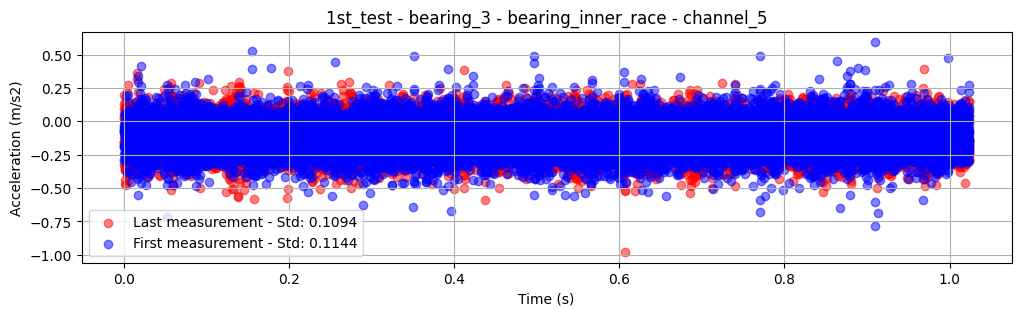

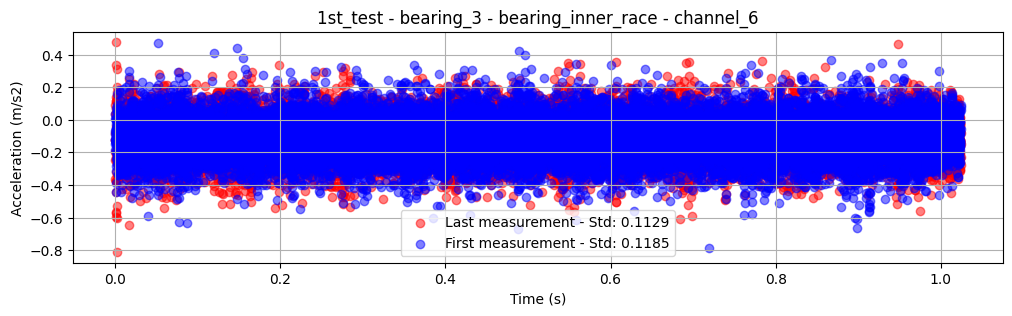

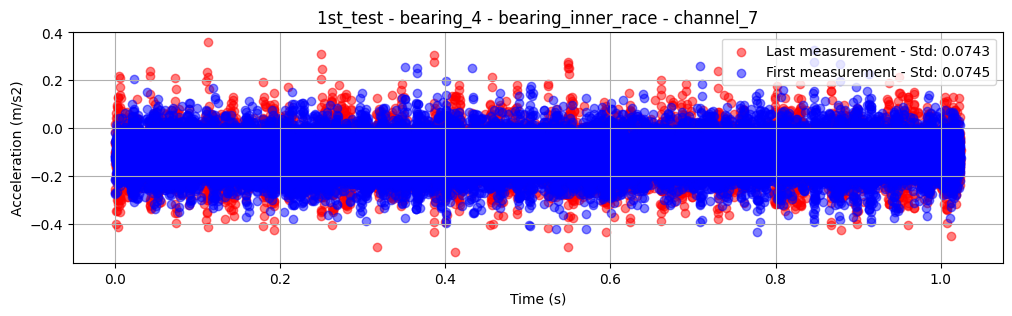

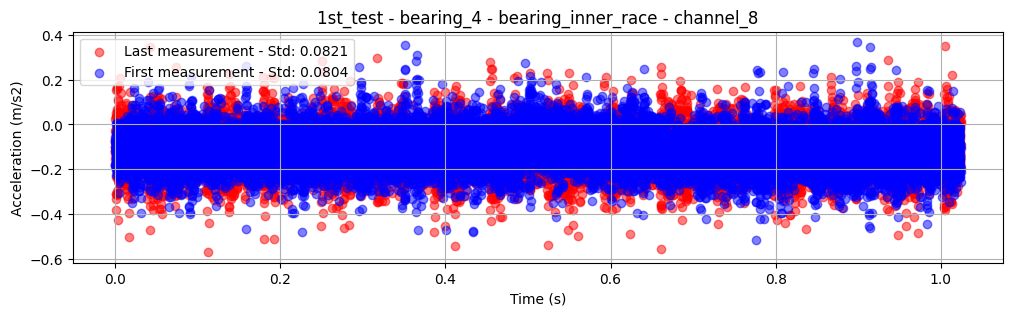

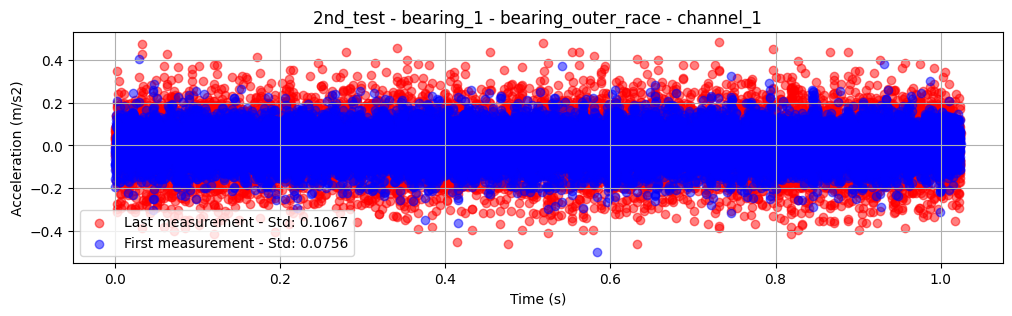

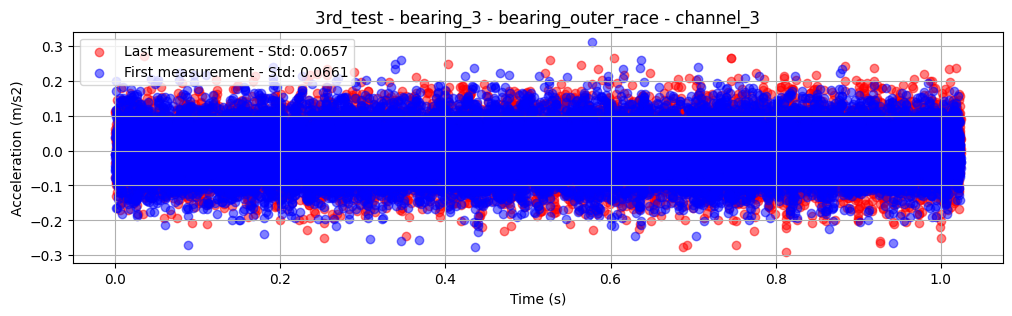

In [10]:
for test, df_list in df_list_per_test.items():
    faulty_bearings = list(FAULTY_BEARINGS_PER_TEST[test].keys())
    fault = list(FAULTY_BEARINGS_PER_TEST[test].values())[0]
    for faulty_bearing in faulty_bearings:
        channels = BEARING_CHANNEL_MAPPING[test][faulty_bearing]
        for channel in channels:                 
            first_measurement = df_list[0]
            last_measurement = df_list[-1]
            first_measurement_std = first_measurement[channel].std()
            last_measurement_std = last_measurement[channel].std()
            plt.figure(figsize=(12, 3))
            plt.scatter(last_measurement['measurement_time_in_seconds'], last_measurement[channel], 
                        label=f'Last measurement - Std: {last_measurement_std:.4f}', color='red', alpha=ALPHA)            
            plt.scatter(first_measurement['measurement_time_in_seconds'], first_measurement[channel], 
                        label=f'First measurement - Std: {first_measurement_std:.4f}', color='blue', alpha=ALPHA)
            plt.legend()
            plt.grid()
            plt.xlabel('Time (s)')
            plt.ylabel('Acceleration (m/s2)')
            plt.title(f'{test} - {faulty_bearing} - {fault} - {channel}')
            plt.show();

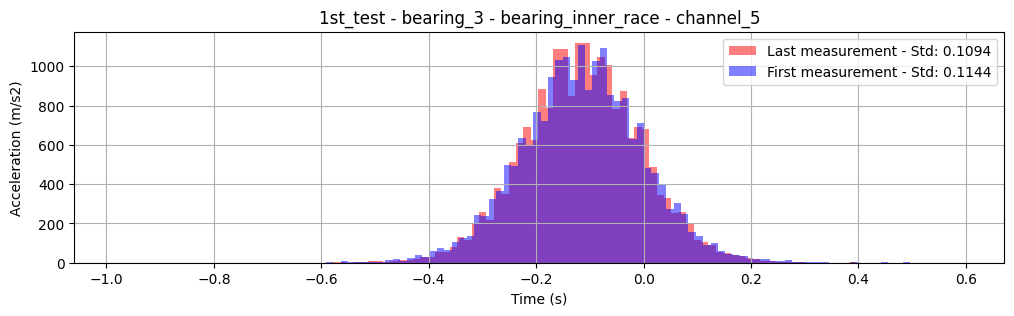

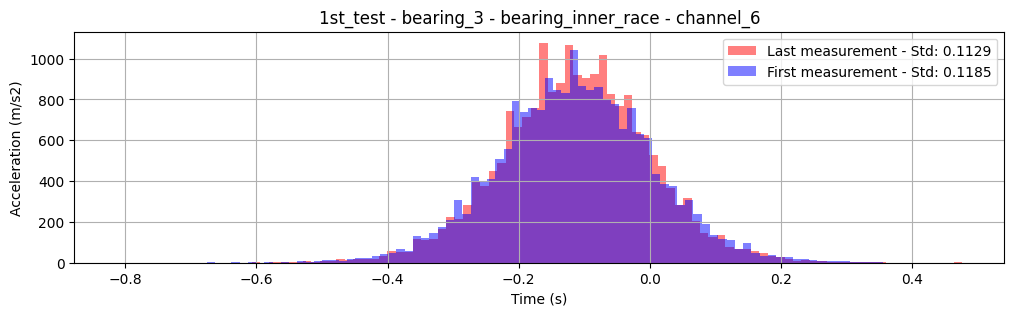

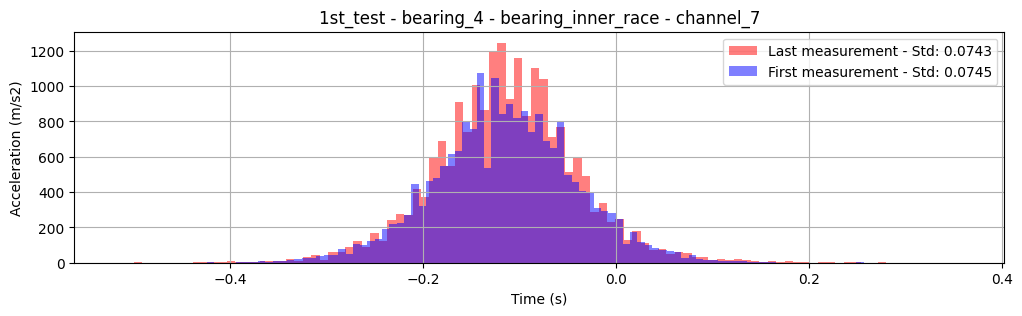

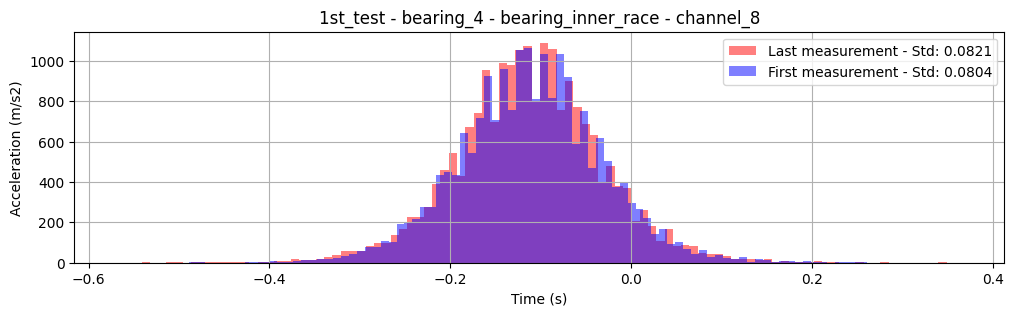

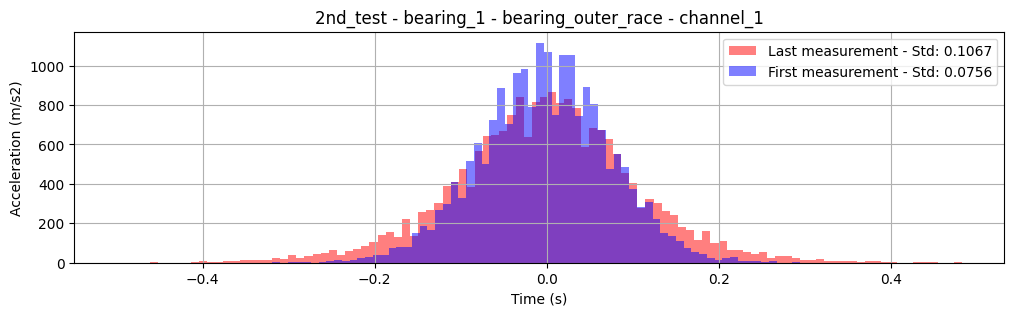

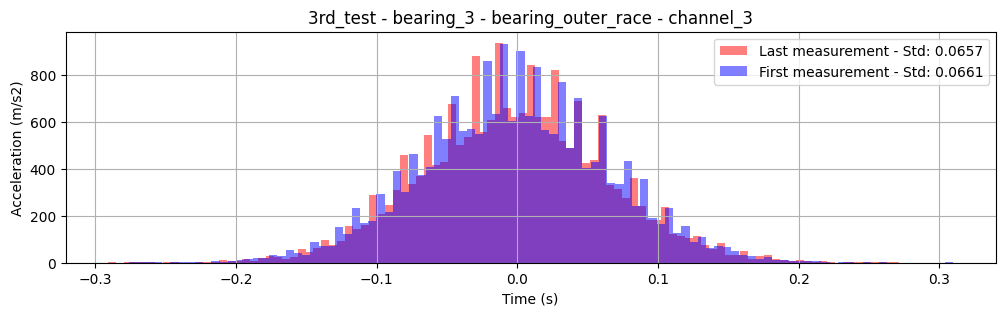

In [11]:
BINS = 100

for test, df_list in df_list_per_test.items():
    faulty_bearings = list(FAULTY_BEARINGS_PER_TEST[test].keys())
    fault = list(FAULTY_BEARINGS_PER_TEST[test].values())[0]
    for faulty_bearing in faulty_bearings:
        channels = BEARING_CHANNEL_MAPPING[test][faulty_bearing]
        for channel in channels:                 
            first_measurement = df_list[0]
            last_measurement = df_list[-1]
            first_measurement_std = first_measurement[channel].std()
            last_measurement_std = last_measurement[channel].std()
            plt.figure(figsize=(12, 3))
            plt.hist(last_measurement[channel], label=f'Last measurement - Std: {last_measurement_std:.4f}', color='red', alpha=ALPHA, bins=BINS)            
            plt.hist(first_measurement[channel], label=f'First measurement - Std: {first_measurement_std:.4f}', color='blue', alpha=ALPHA, bins=BINS)
            plt.legend()
            plt.grid()
            plt.xlabel('Time (s)')
            plt.ylabel('Acceleration (m/s2)')
            plt.title(f'{test} - {faulty_bearing} - {fault} - {channel}')
            plt.show();

Let's check all the channels in histograms to see if there is any other finding:

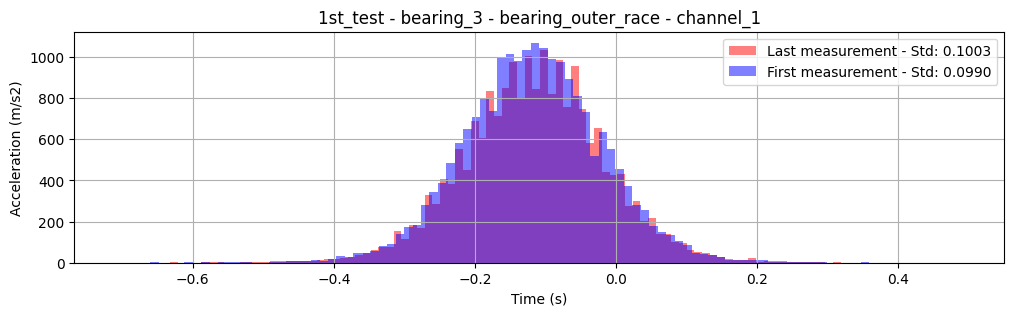

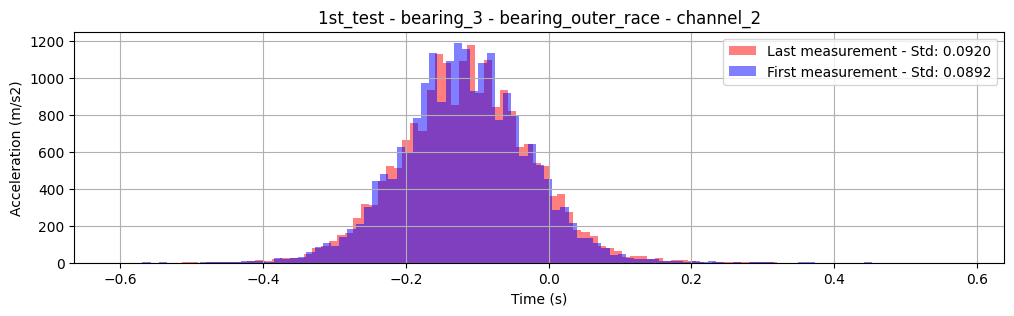

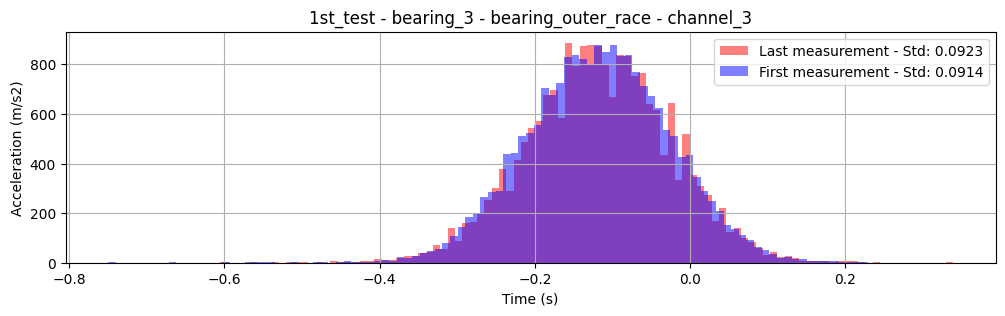

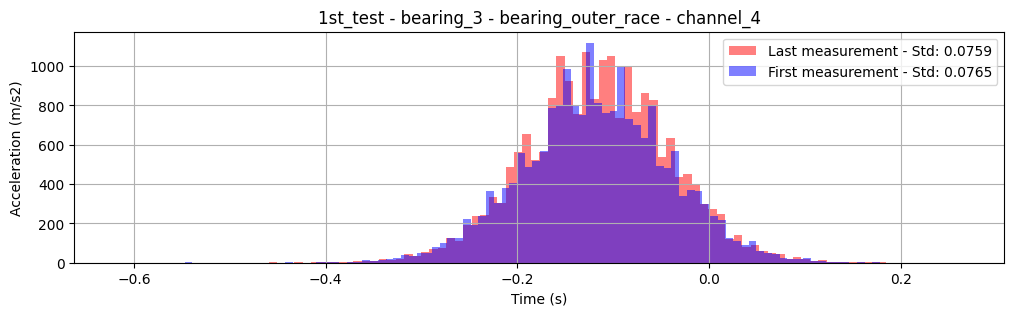

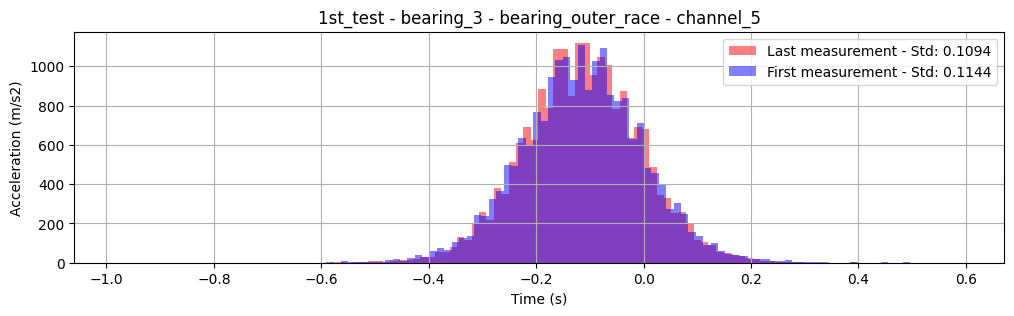

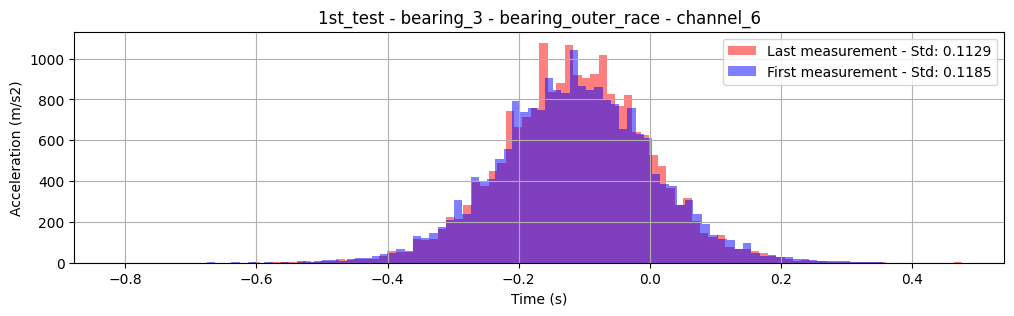

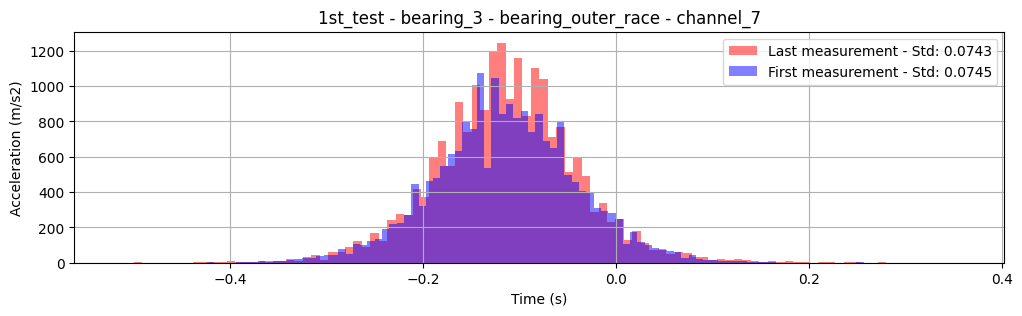

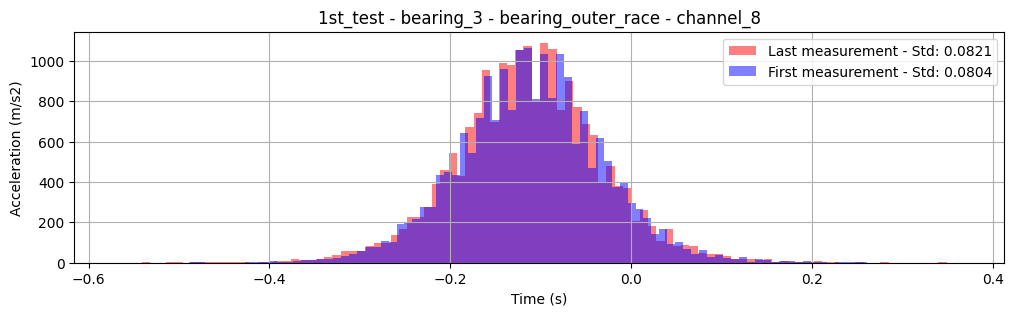

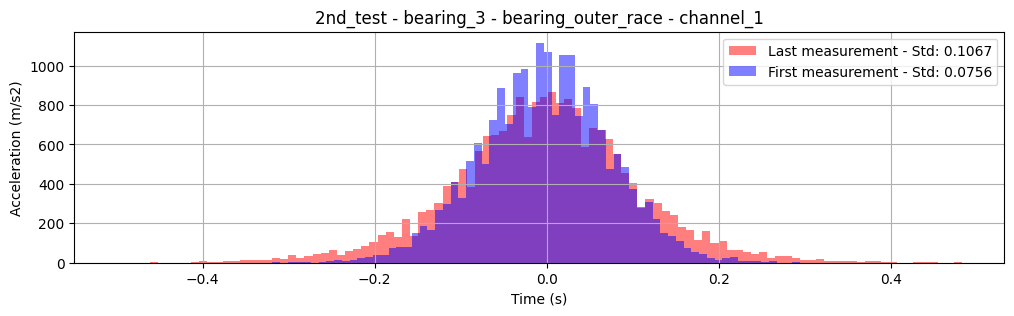

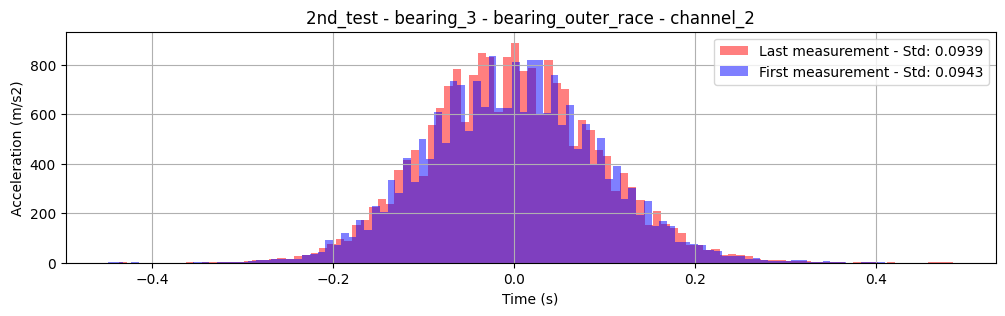

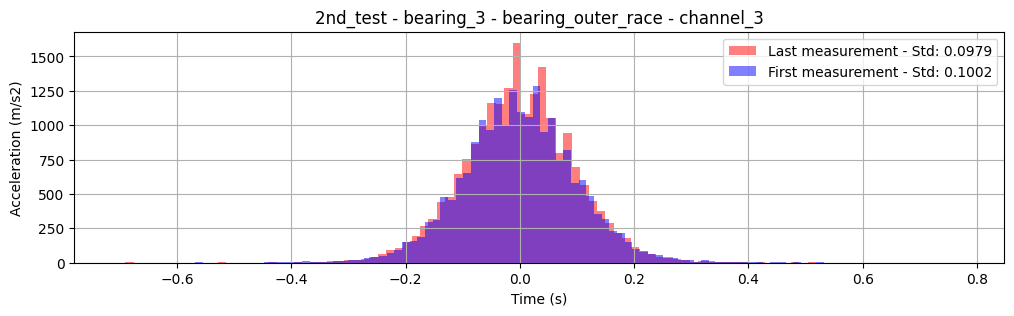

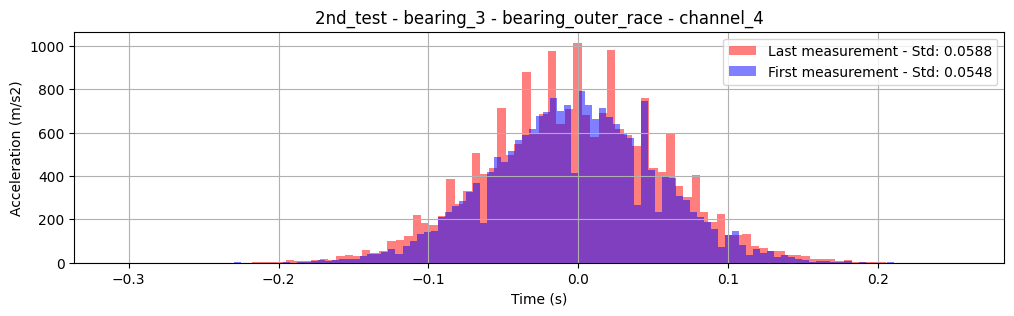

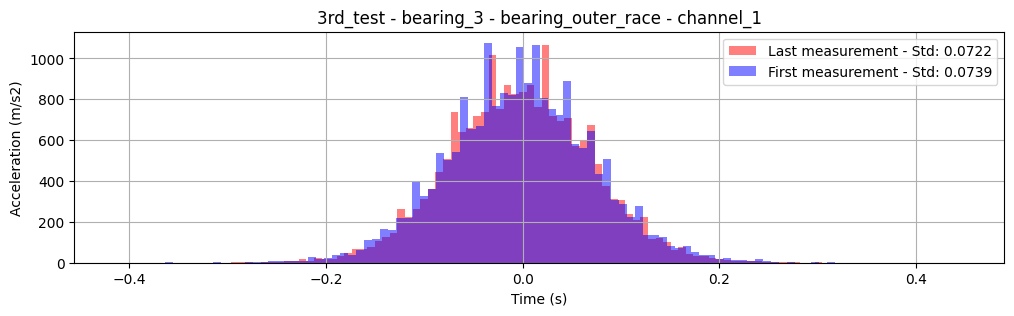

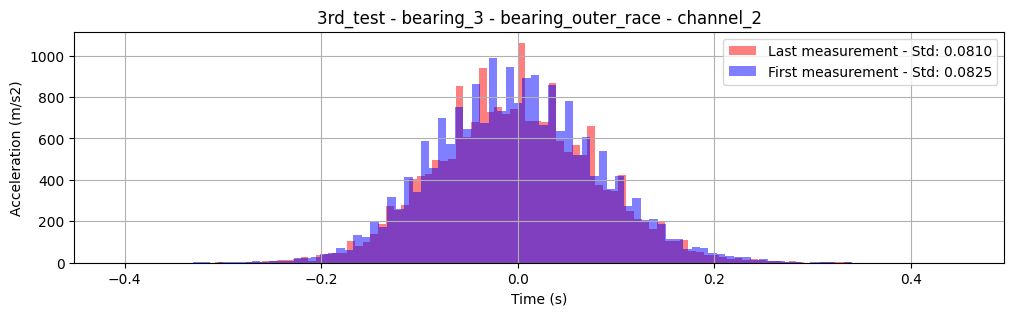

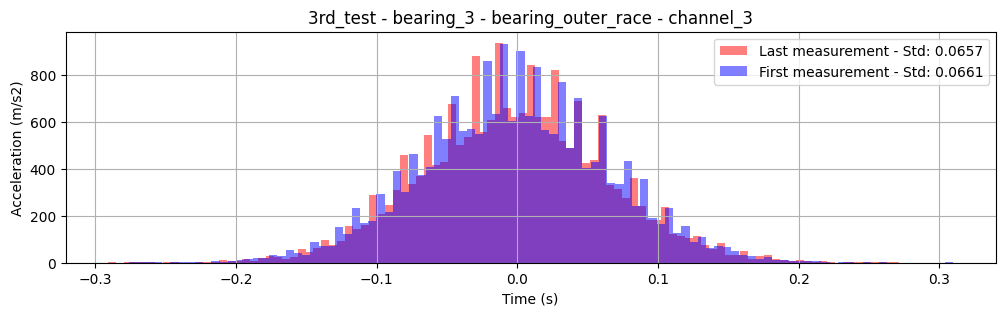

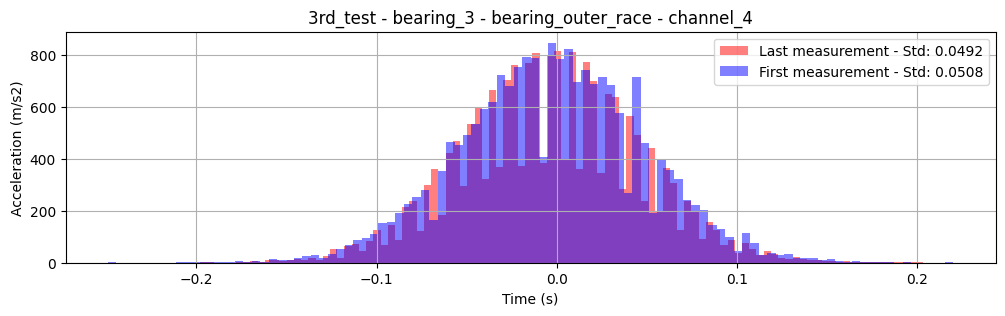

In [12]:
for test, df_list in df_list_per_test.items():
    for bearings, channels in BEARING_CHANNEL_MAPPING[test].items():
        for channel in channels:
            first_measurement = df_list[0]
            last_measurement = df_list[-1]
            first_measurement_std = first_measurement[channel].std()
            last_measurement_std = last_measurement[channel].std()
            plt.figure(figsize=(12, 3))
            plt.hist(last_measurement[channel], label=f'Last measurement - Std: {last_measurement_std:.4f}', color='red', alpha=ALPHA, bins=BINS)            
            plt.hist(first_measurement[channel], label=f'First measurement - Std: {first_measurement_std:.4f}', color='blue', alpha=ALPHA, bins=BINS)
            plt.legend()
            plt.grid()
            plt.xlabel('Time (s)')
            plt.ylabel('Acceleration (m/s2)')
            plt.title(f'{test} - {faulty_bearing} - {fault} - {channel}')
            plt.show();

## First conclusions
Considering the previous plots, these are the first conclusions per test:

- **1st test**: No clear evidence of a bearing fault happening when comparing the first and the last measurement

- **2nd test**: The last measurement for channel 1, which corresponds to bearing 1, has a wider histogram than the first measurement. Therefore, the vibration amplitude has increased from the first measurement to the last measurement. That increase in vibration explains the bearing failure, since faulty bearings tend to have greater vibration amplitudes than before when they were healthy.

- **3rd test**: No clear evidence of a bearing fault happening when comparing the first and the last measurement

As a next step, the different aggregations will be performed on the vibration measurements to see if bearing failures can be better detected.

## Aggregation

Different aggregation functions are used to better understand the evolution of the failure using the time-series data:

In [13]:
all_aggregated_results = {}

for test, df_list in df_list_per_test.items():
    logger.info(test)
    df = pl.concat(df_list, how='vertical')
    faulty_bearings = list(FAULTY_BEARINGS_PER_TEST[test].keys())
    all_aggregated_results[test] = {}   
    
    for faulty_bearing in faulty_bearings:
        logger.info(faulty_bearing)
        channels = BEARING_CHANNEL_MAPPING[test][faulty_bearing]   
        logger.info(channels)
        all_aggregated_results[test][faulty_bearing] = {}   

        expressions = []
        for channel in channels:
            expressions.extend([
                pl.col(channel).max().alias(f'max_{channel}'),
                pl.col(channel).min().alias(f'min_{channel}'),
                pl.col(channel).mean().alias(f'mean_{channel}'),
                pl.col(channel).std().alias(f'std_{channel}'),
                pl.col(channel).var().alias(f'var_{channel}'),
                pl.col(channel).kurtosis().alias(f'kurtosis_{channel}'),
                pl.col(channel).skew().alias(f'skewness_{channel}'),
                pl.col(channel).map_batches(lambda s: signals.root_mean_square(s.to_numpy()),
                                            return_dtype=pl.Float64,
                                            returns_scalar=True)
                                            .alias(f'rms_{channel}'),                                           
                pl.col(channel).map_batches(lambda s: signals.crest_factor(s.to_numpy()),
                                            return_dtype=pl.Float64,
                                            returns_scalar=True)
                                            .alias(f'crest_factor_{channel}'),
                pl.col(channel).map_batches(lambda s: signals.shape_factor(s.to_numpy()),
                                            return_dtype=pl.Float64,
                                            returns_scalar=True)
                                            .alias(f'shape_factor_{channel}')
            ])

        aggregated_df = (
                df
                .group_by("file_name")
                .agg(expressions)
            )       

        aggregated_df = aggregated_df.with_columns(
            pl.col("file_name").str.strptime(
                pl.Datetime,
                format="%Y.%m.%d.%H.%M.%S"
            ).alias("date_time")
        )
                
        all_aggregated_results[test][faulty_bearing] = aggregated_df

2026-01-30 11:52:27.754 | INFO     | __main__:<module>:4 - 1st_test
2026-01-30 11:52:27.790 | INFO     | __main__:<module>:10 - bearing_3
2026-01-30 11:52:27.791 | INFO     | __main__:<module>:12 - ['channel_5', 'channel_6']
2026-01-30 11:52:29.321 | INFO     | __main__:<module>:10 - bearing_4
2026-01-30 11:52:29.321 | INFO     | __main__:<module>:12 - ['channel_7', 'channel_8']
2026-01-30 11:52:30.857 | INFO     | __main__:<module>:4 - 2nd_test
2026-01-30 11:52:30.892 | INFO     | __main__:<module>:10 - bearing_1
2026-01-30 11:52:30.893 | INFO     | __main__:<module>:12 - ['channel_1']
2026-01-30 11:52:31.817 | INFO     | __main__:<module>:4 - 3rd_test
2026-01-30 11:52:31.874 | INFO     | __main__:<module>:10 - bearing_3
2026-01-30 11:52:31.875 | INFO     | __main__:<module>:12 - ['channel_3']


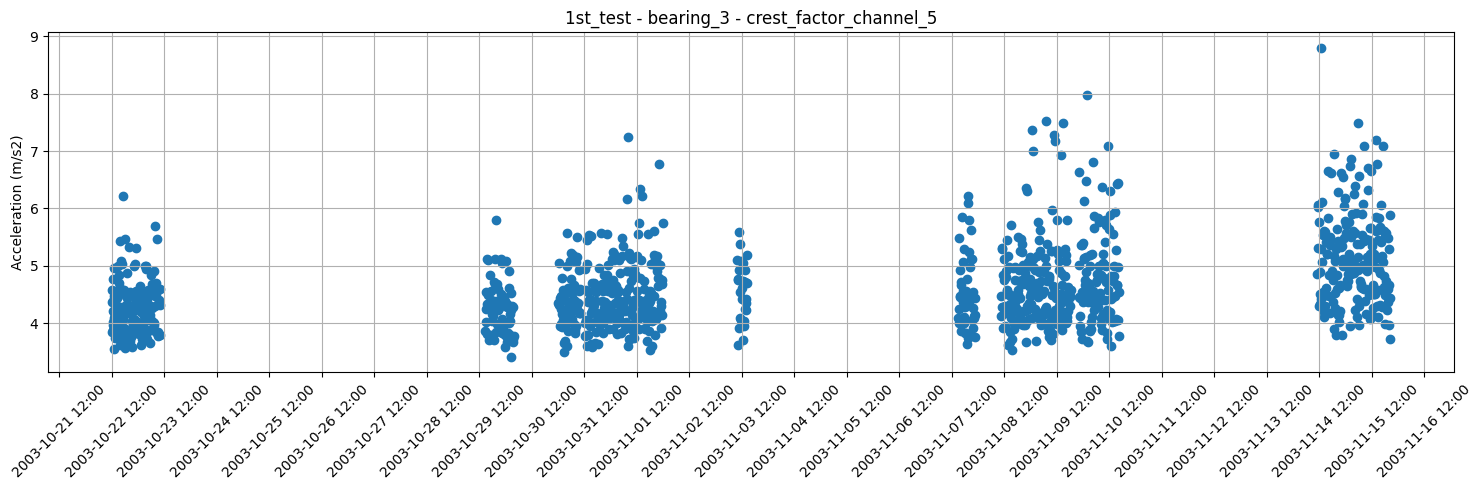

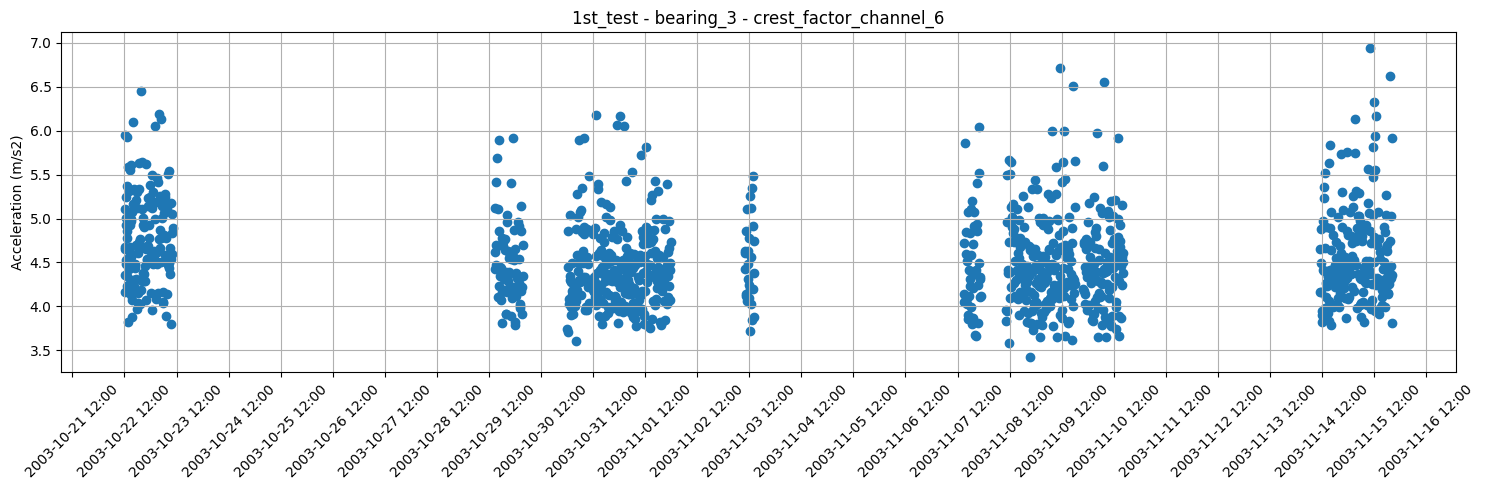

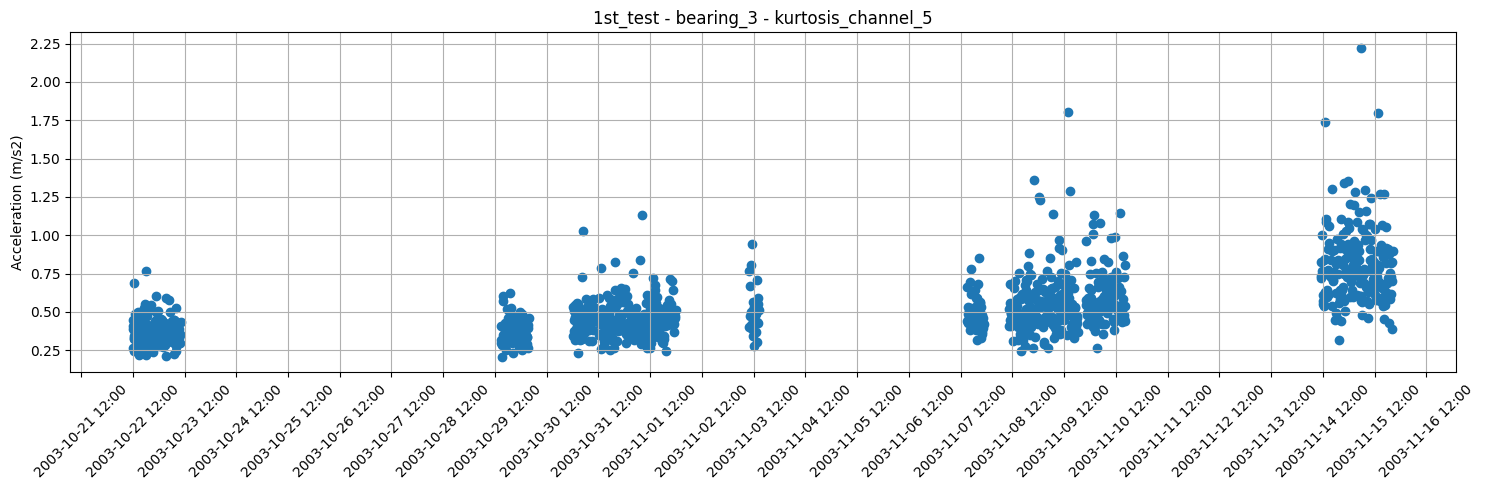

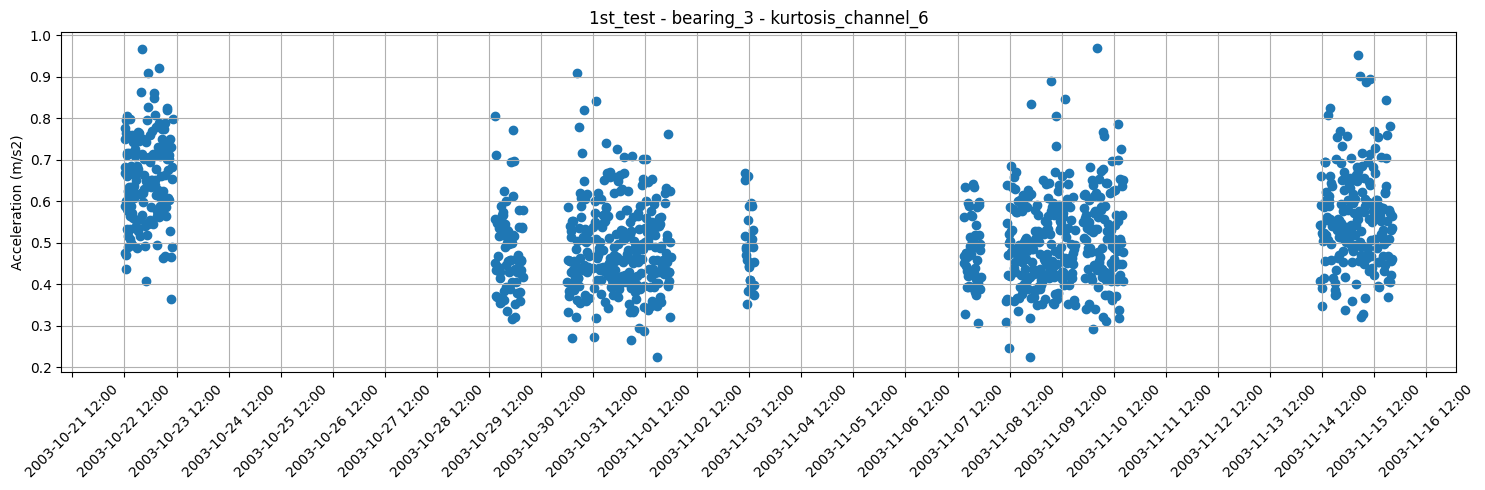

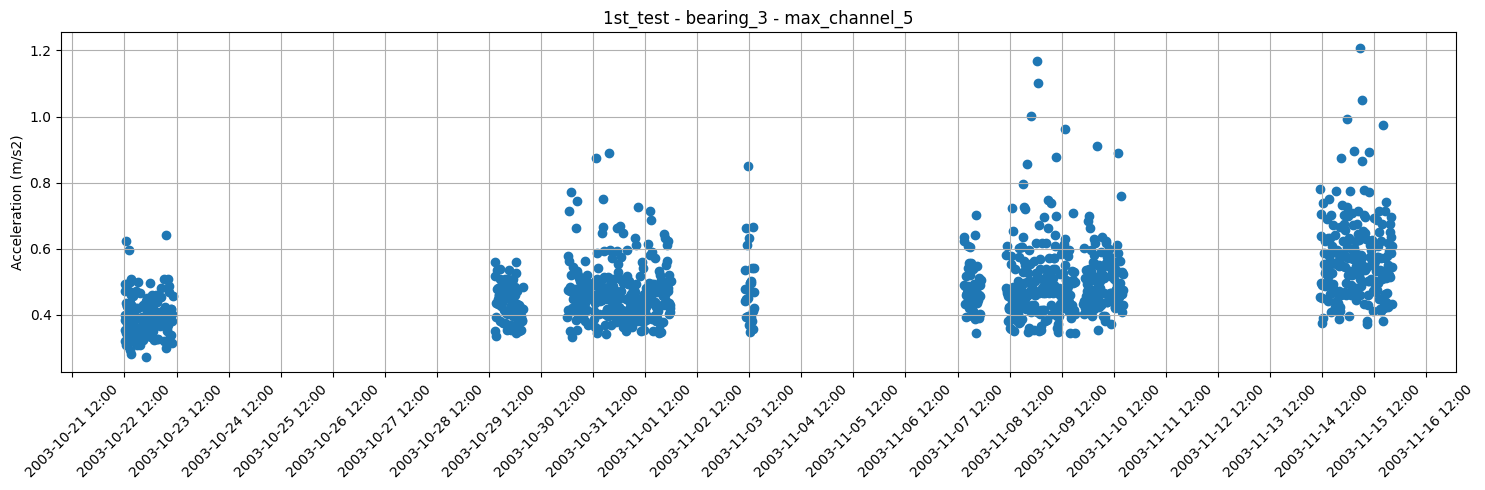

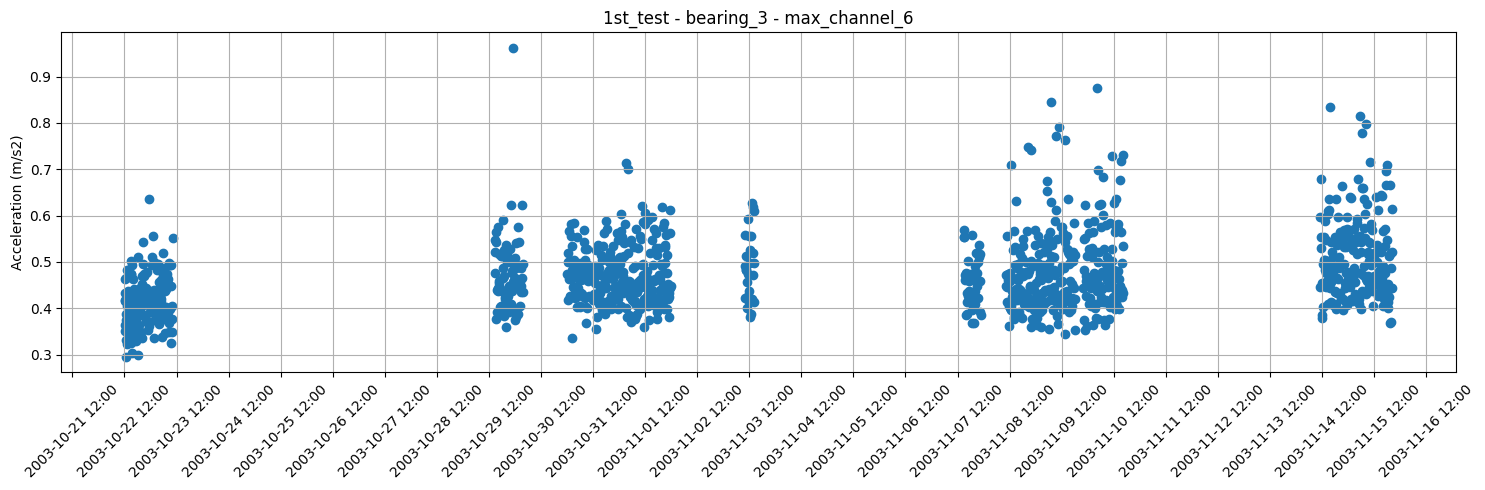

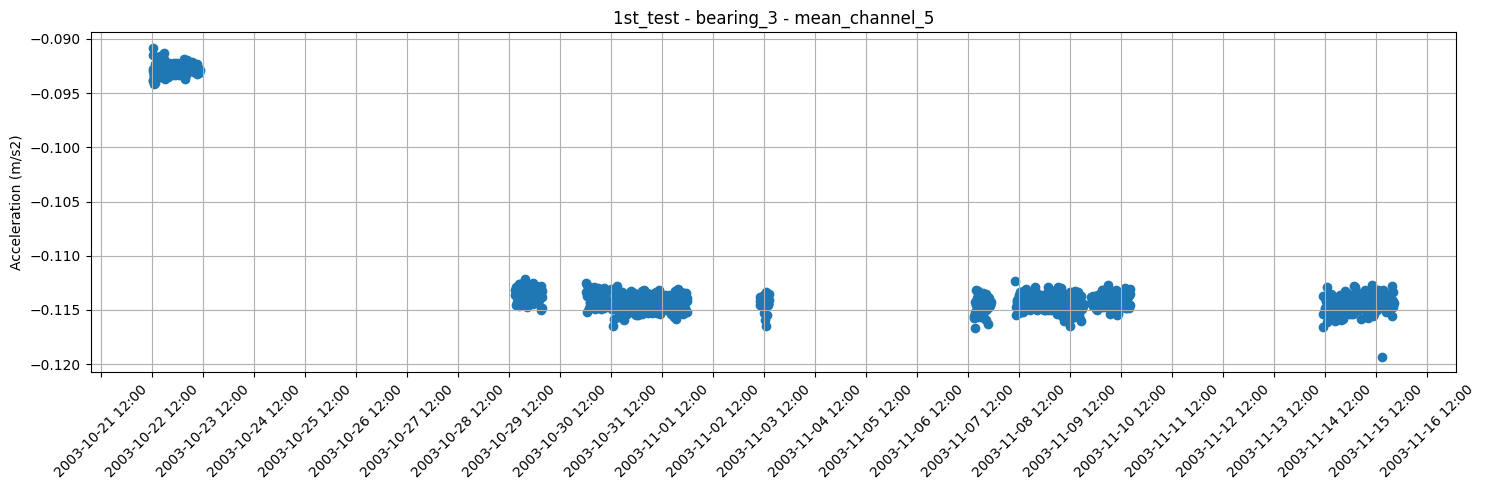

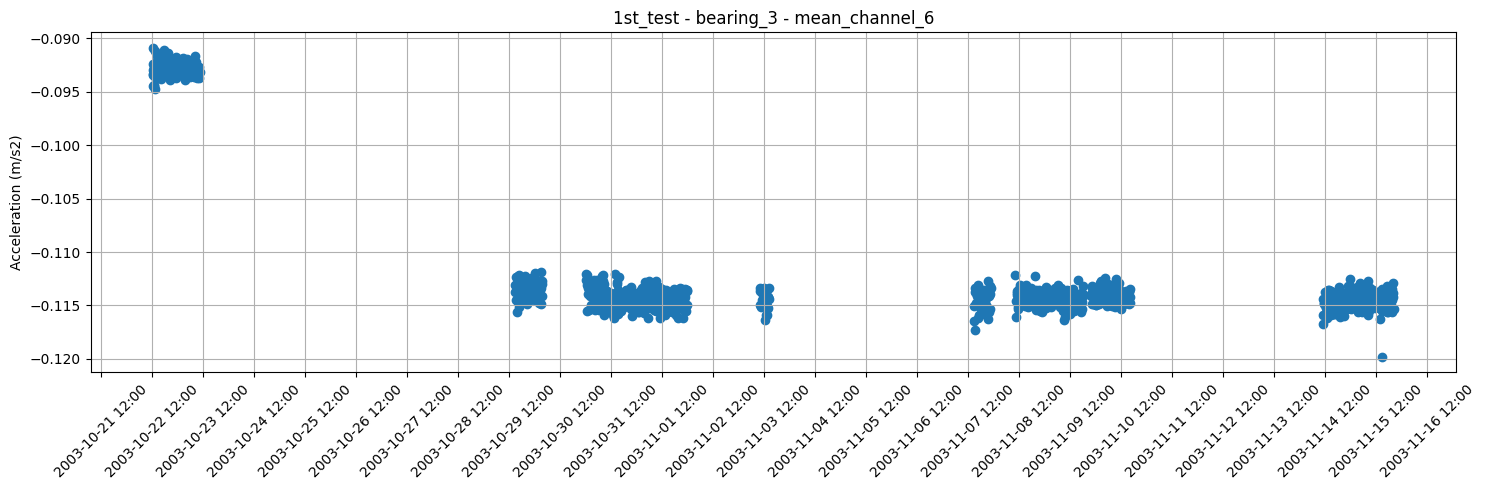

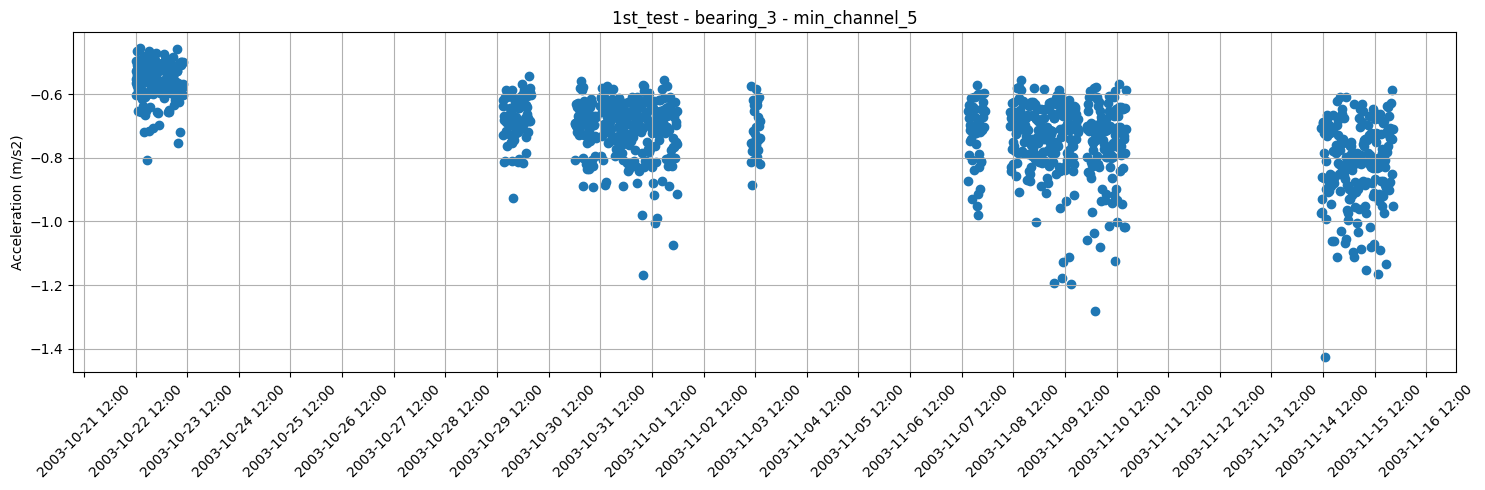

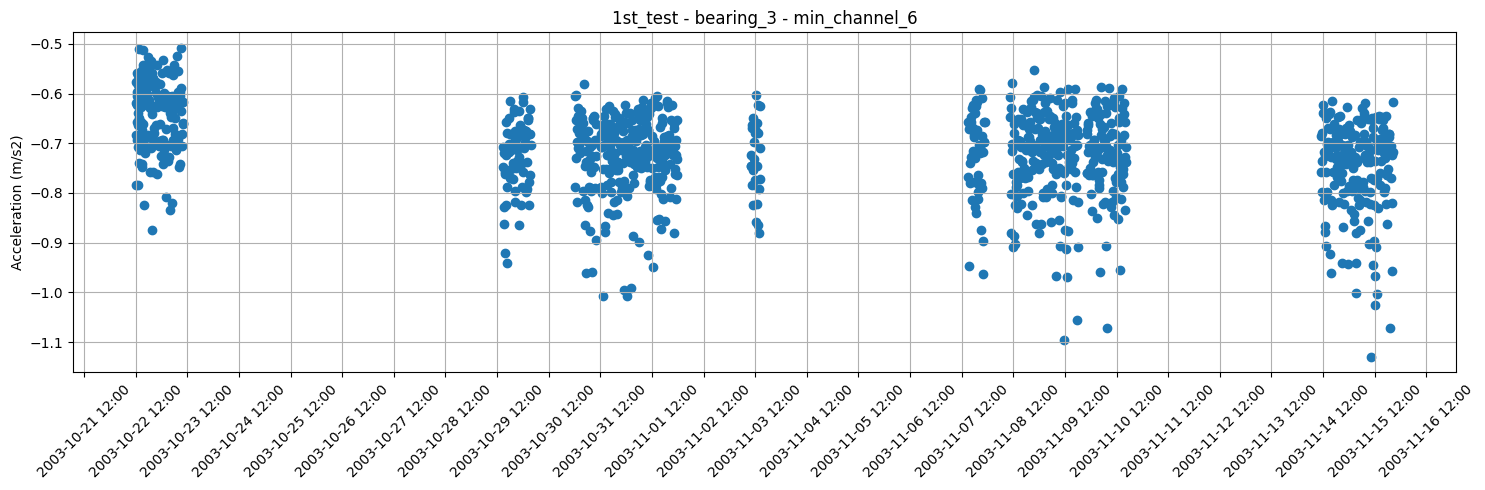

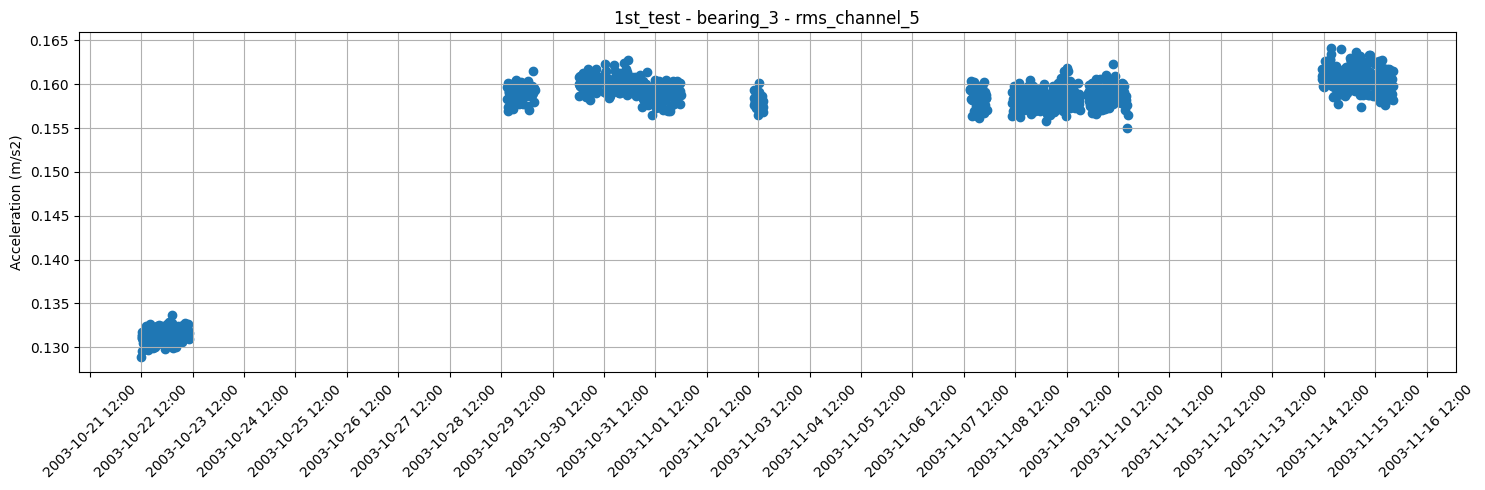

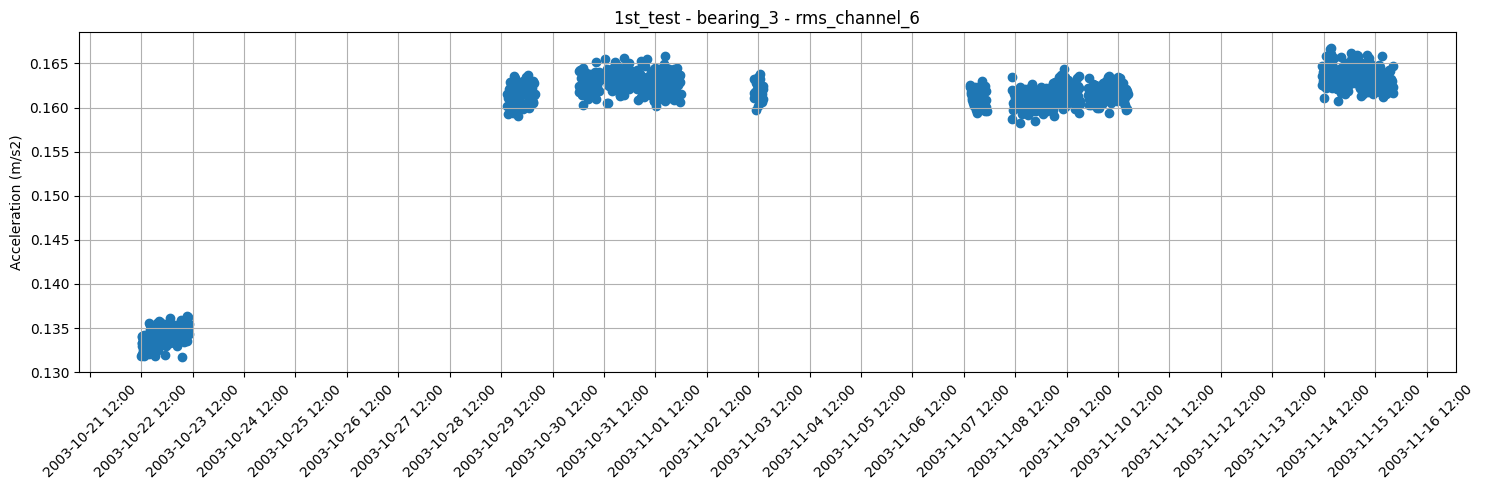

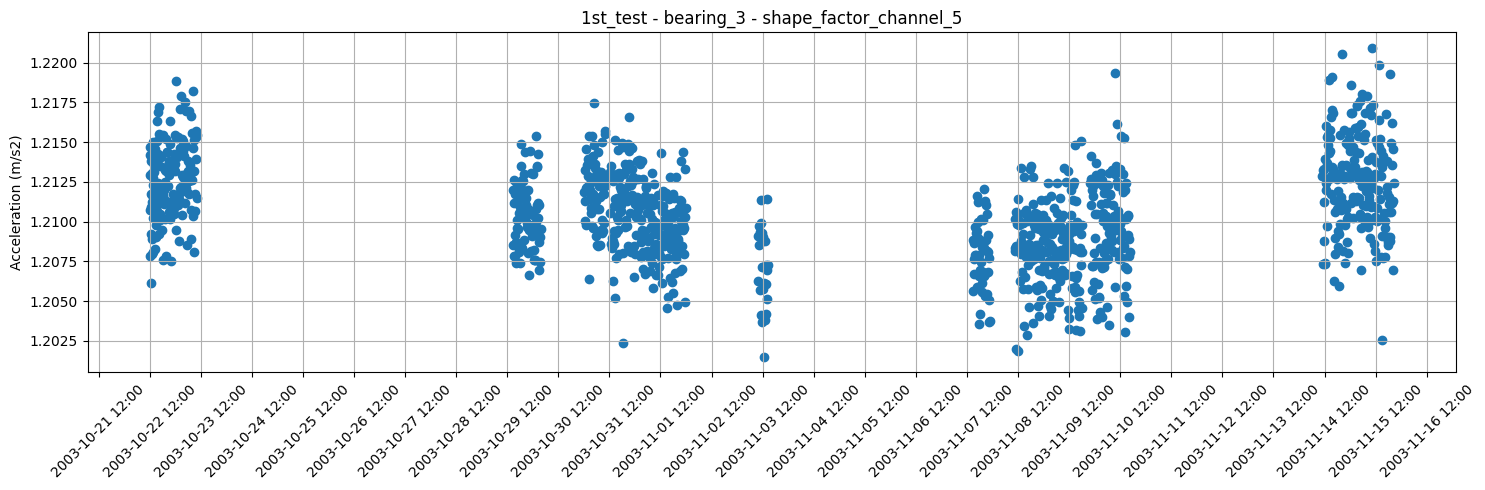

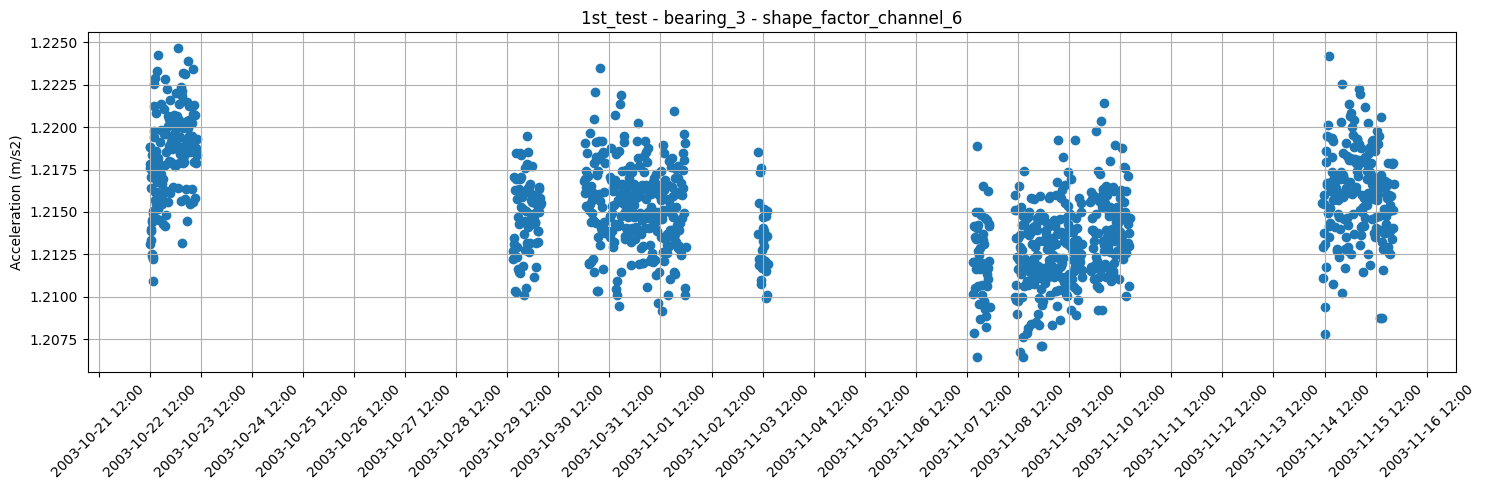

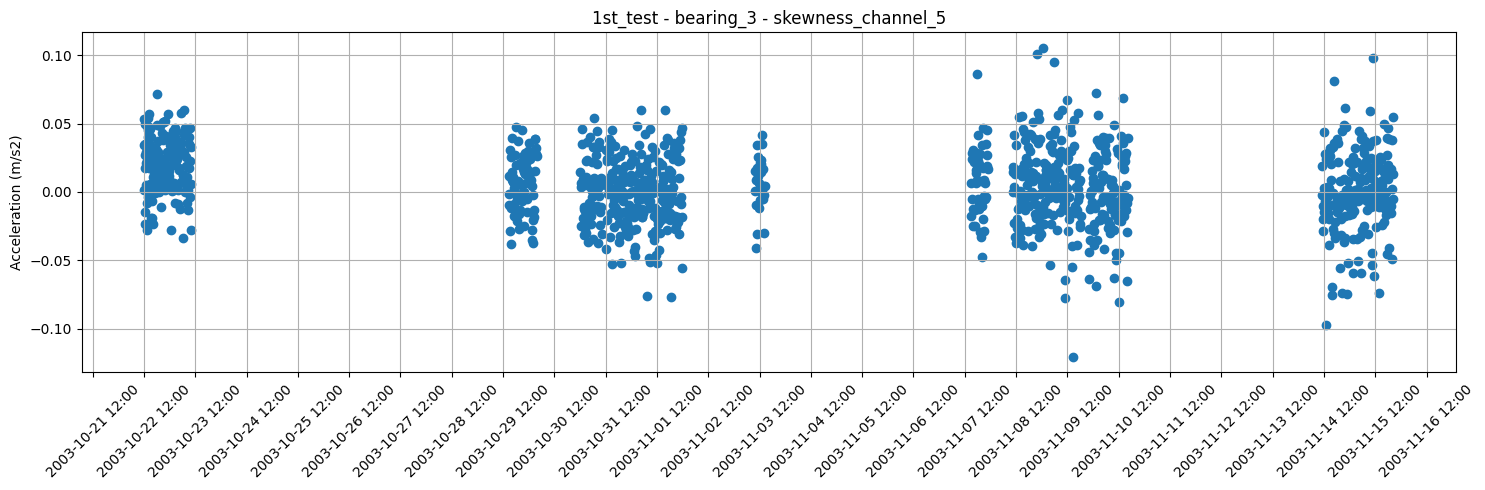

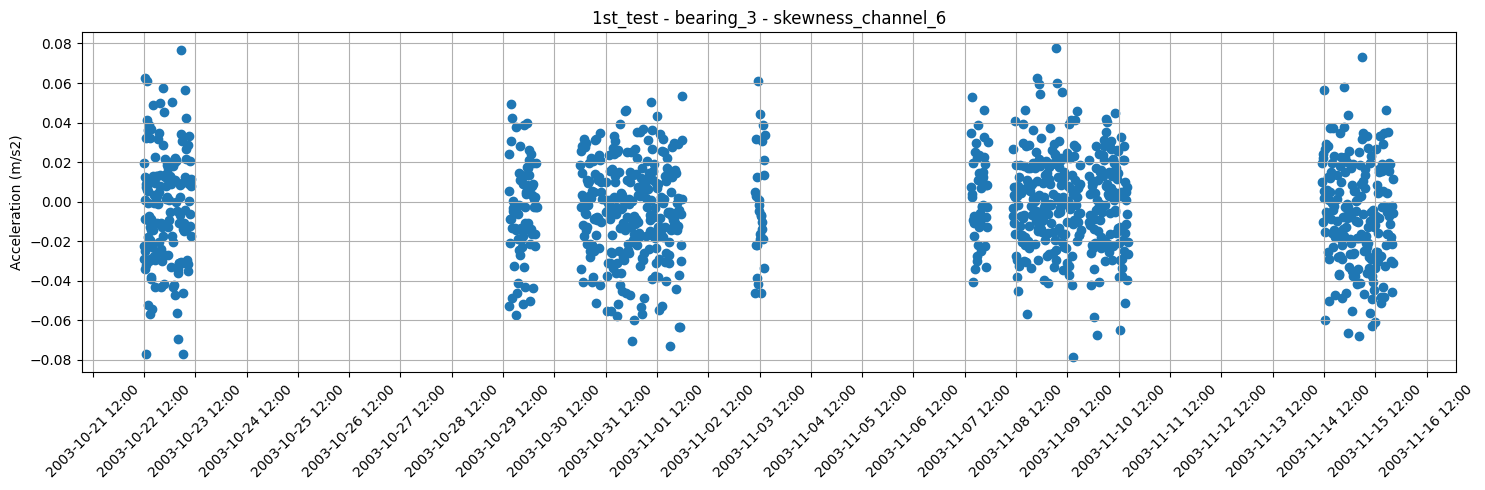

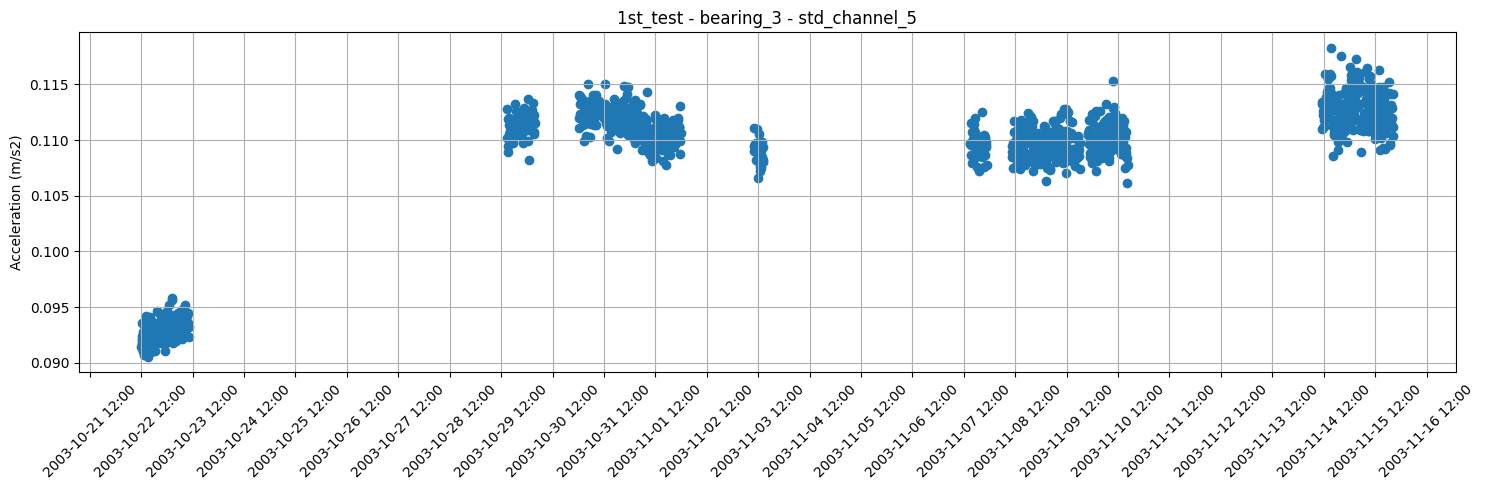

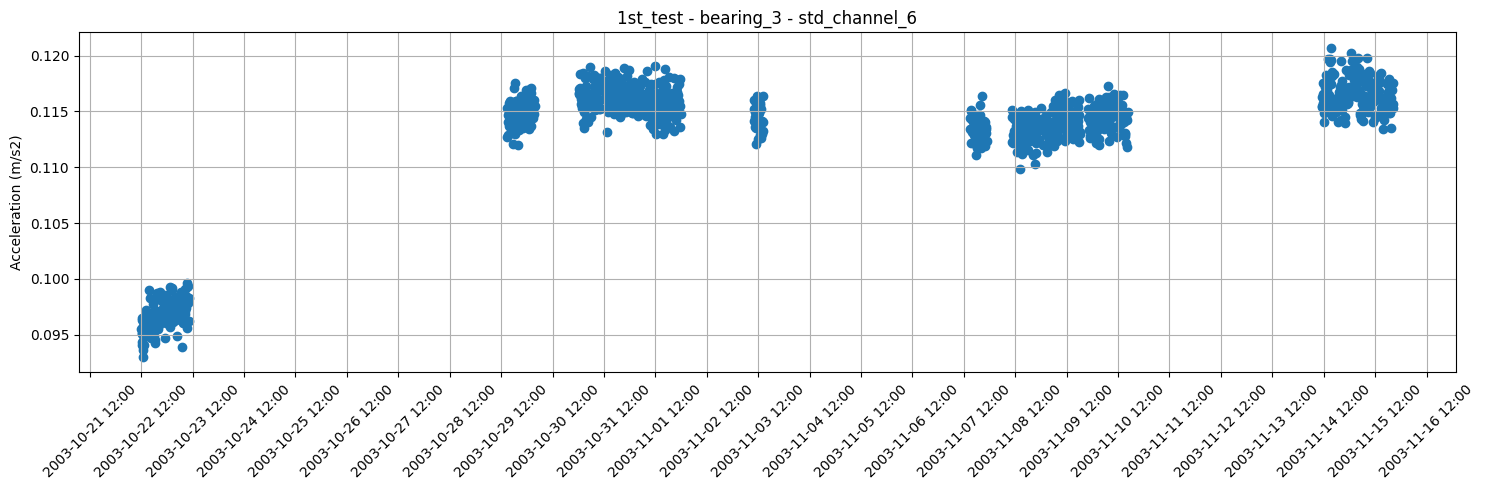

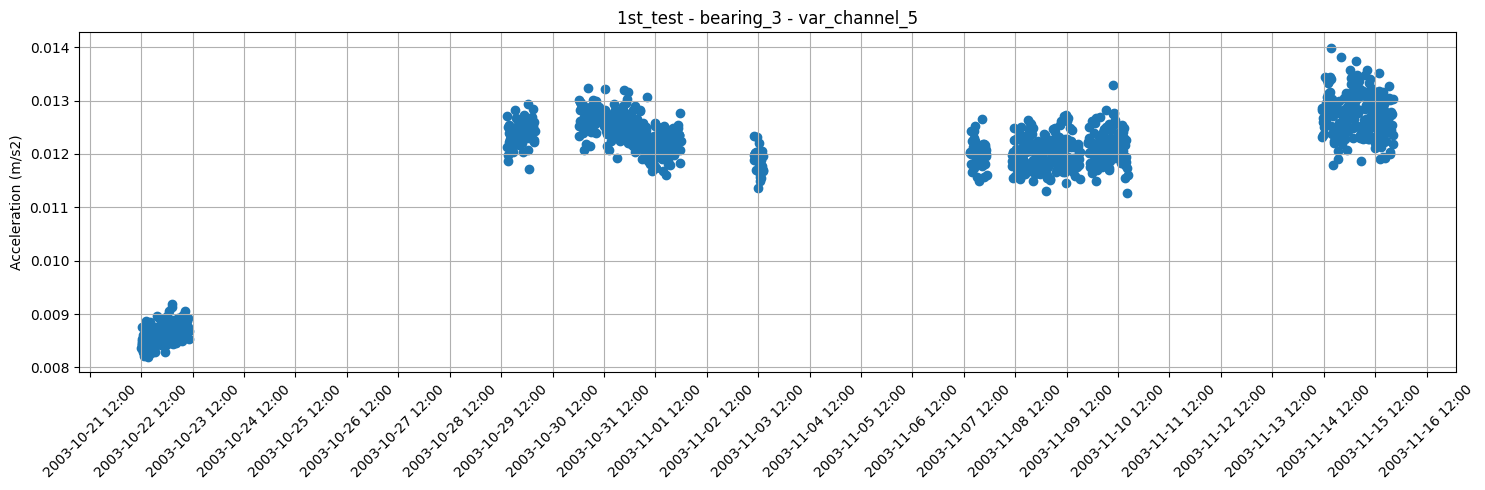

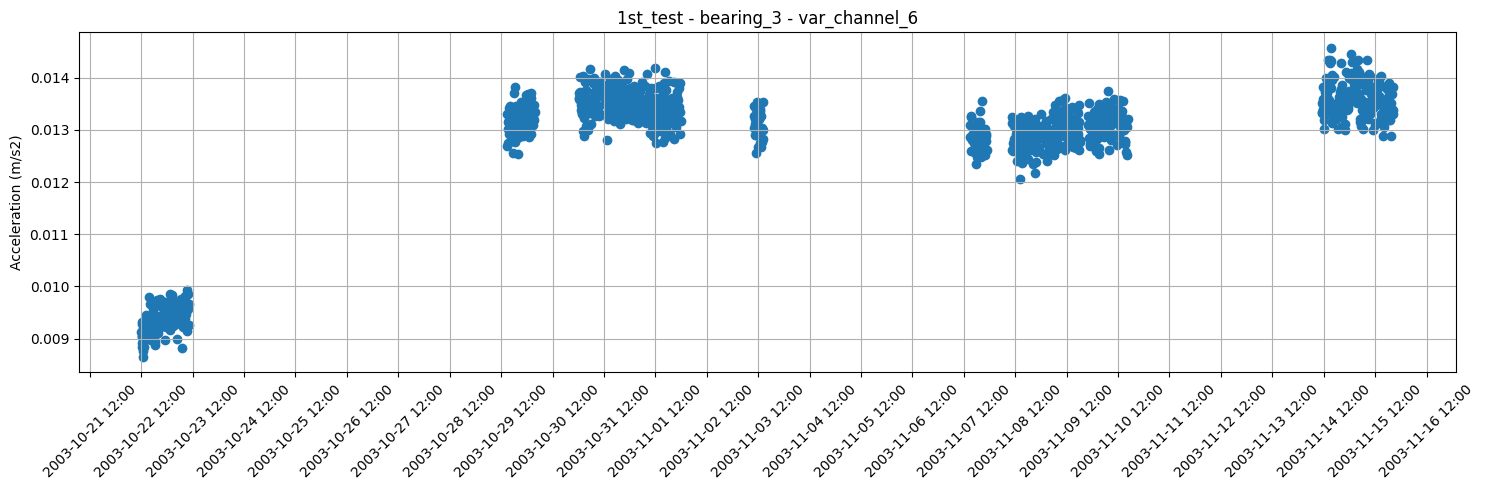

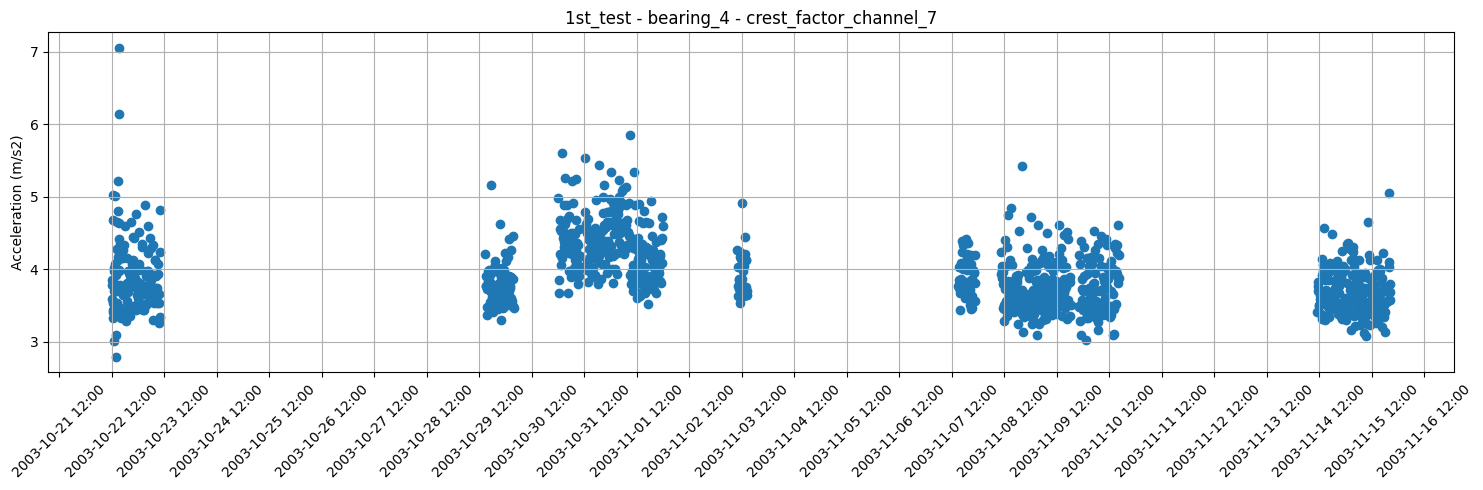

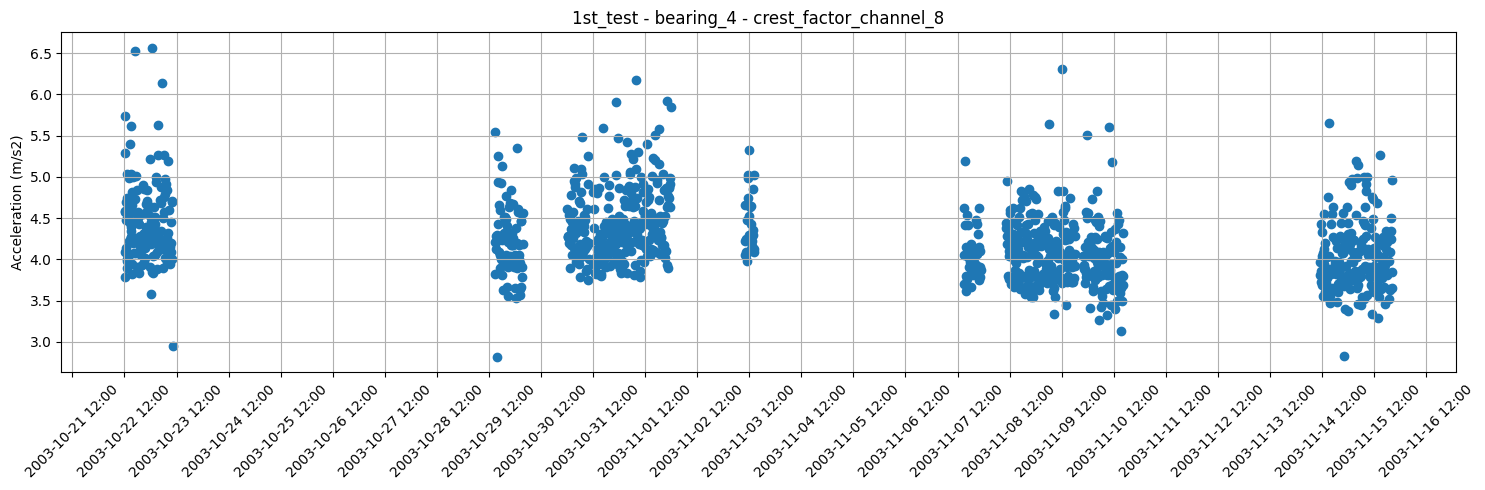

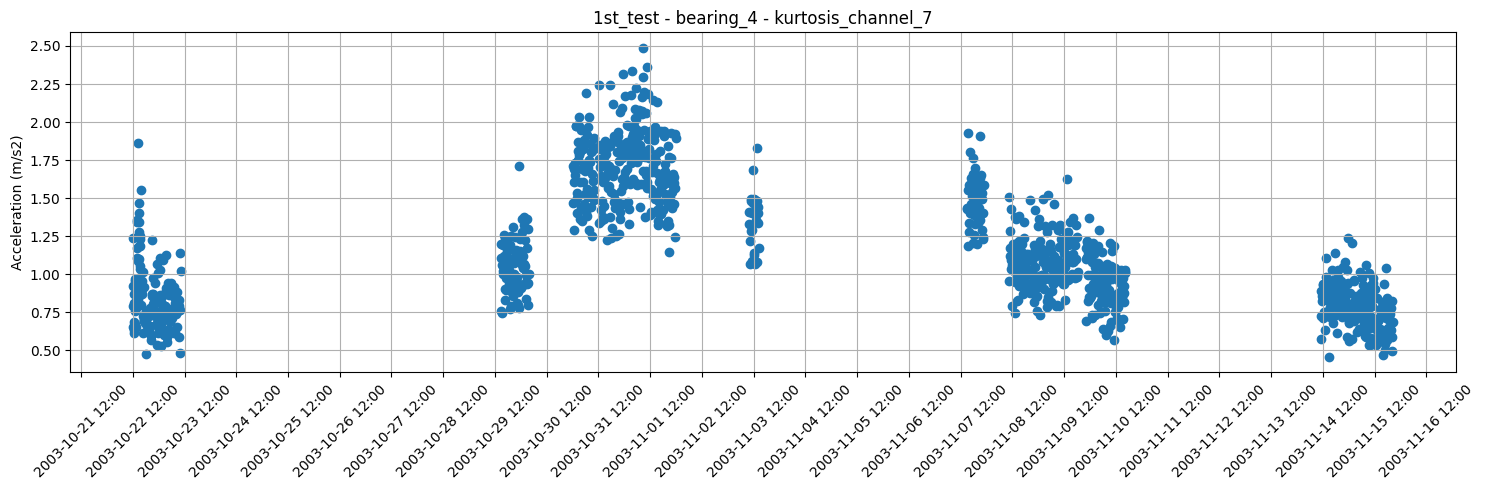

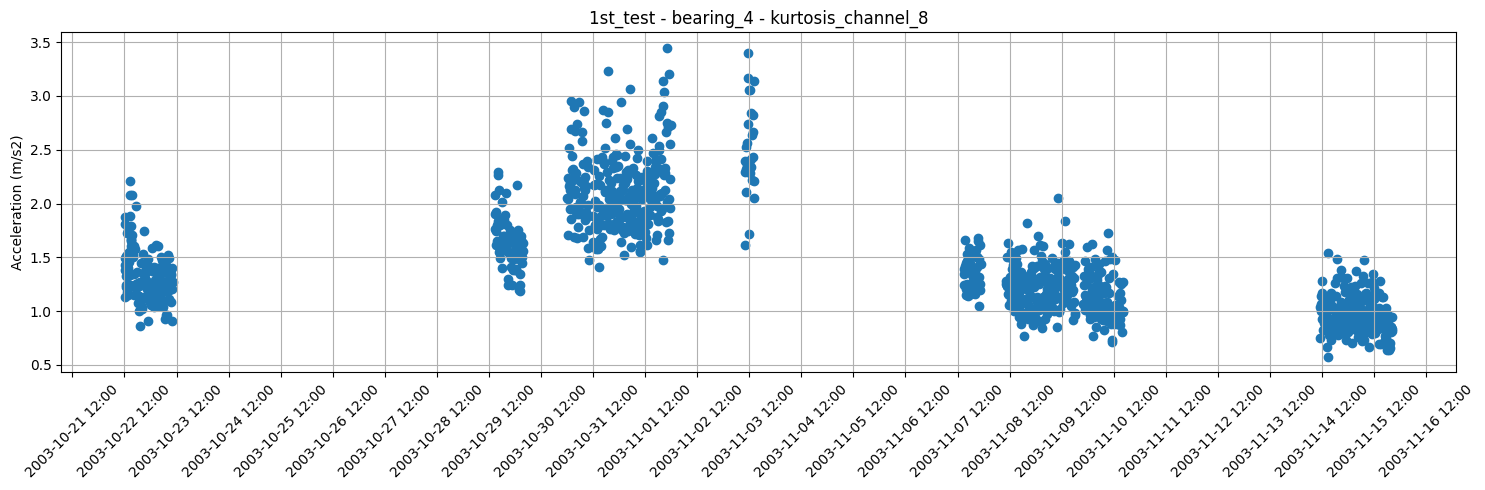

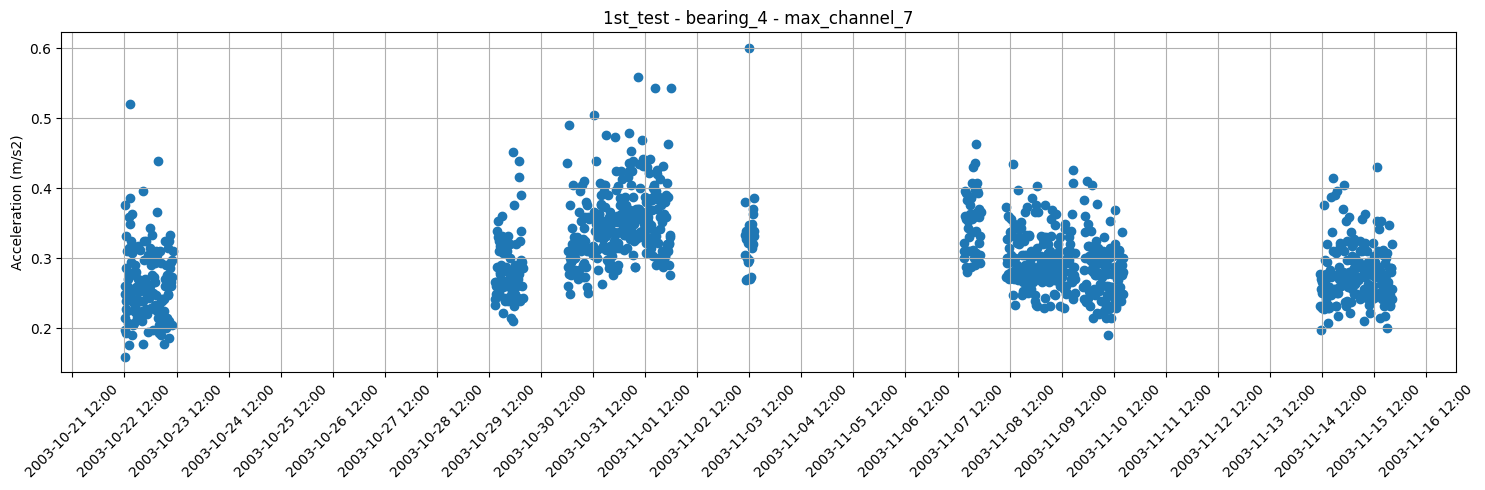

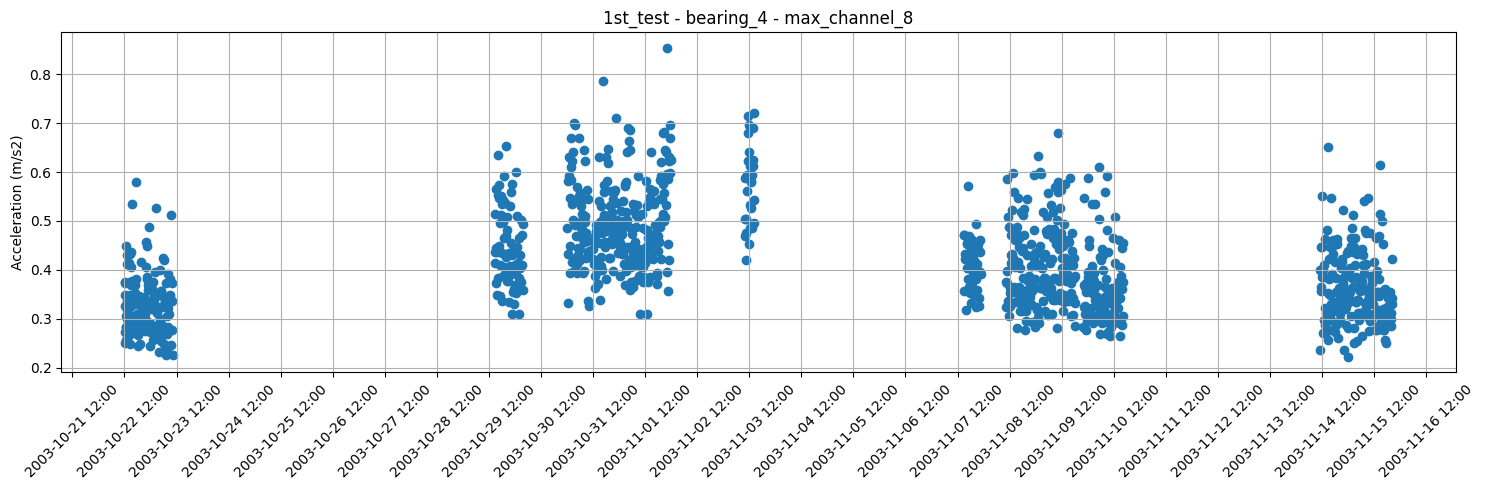

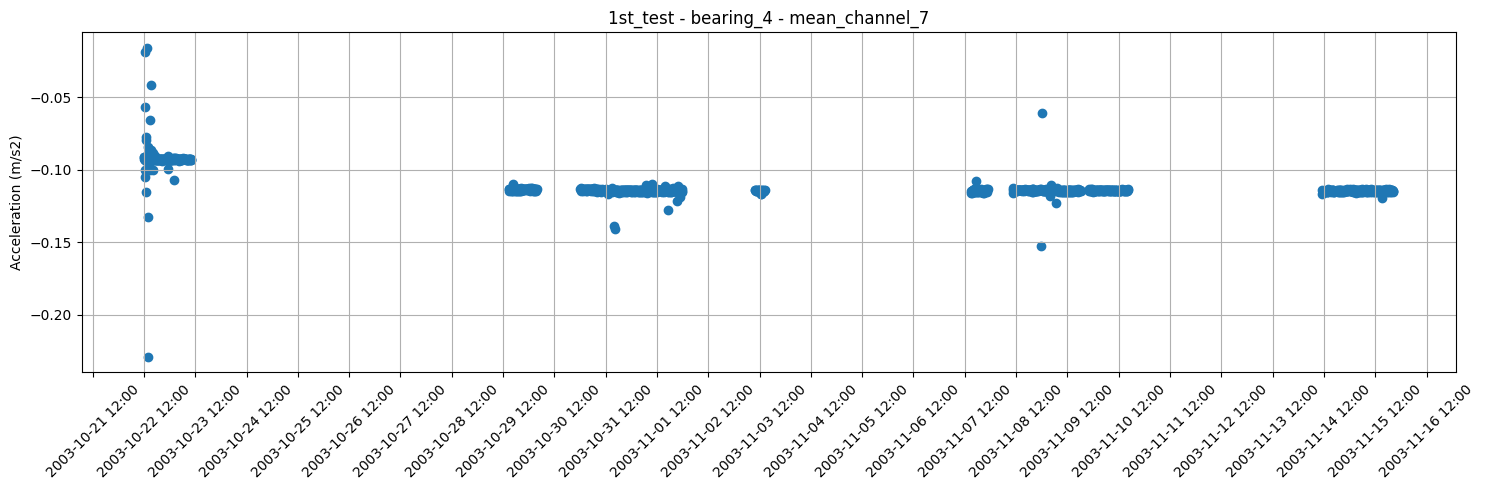

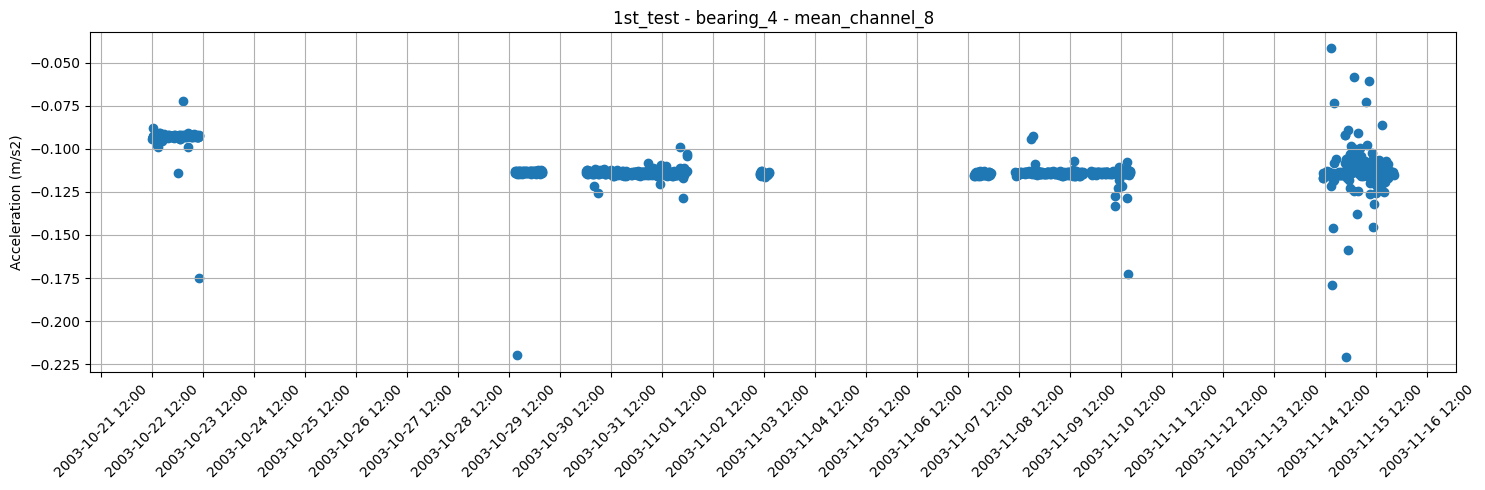

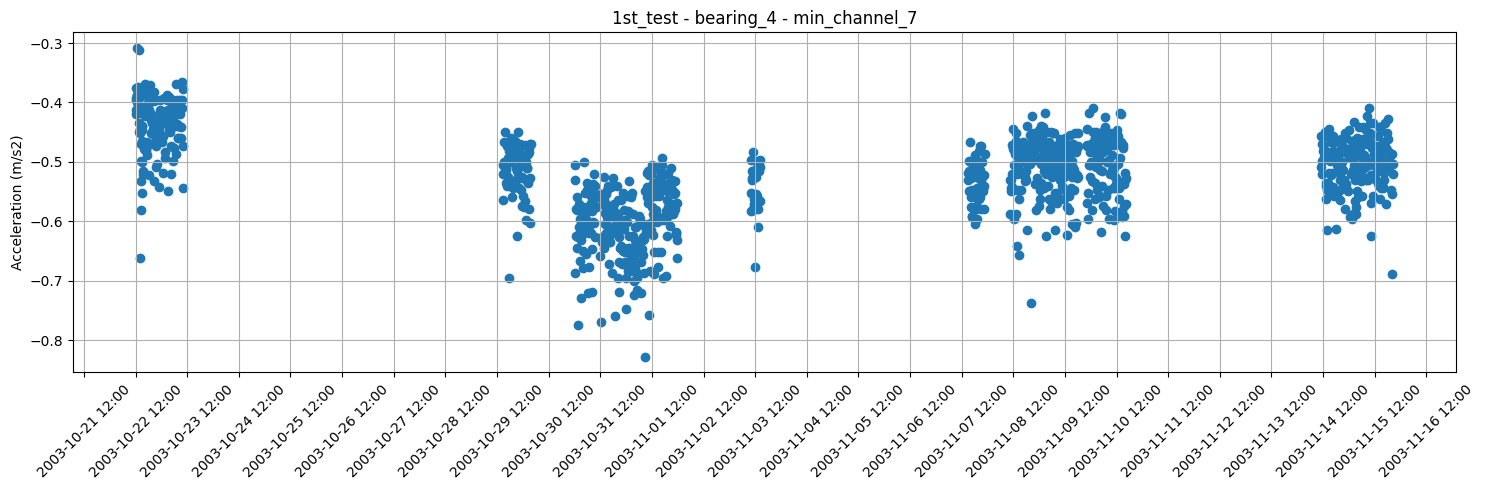

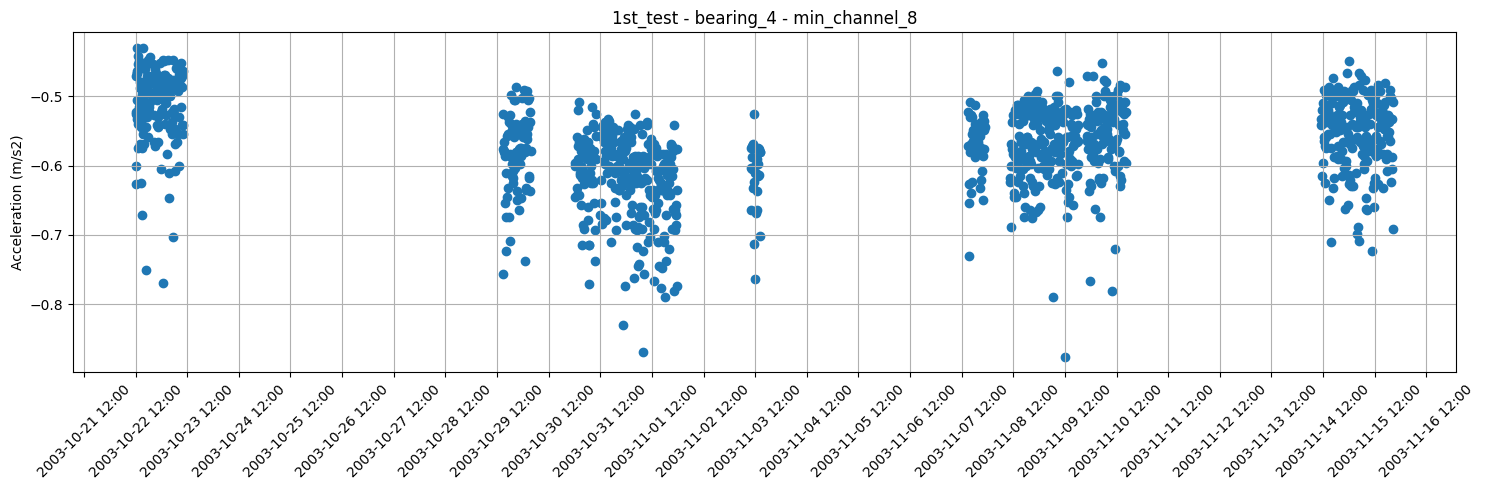

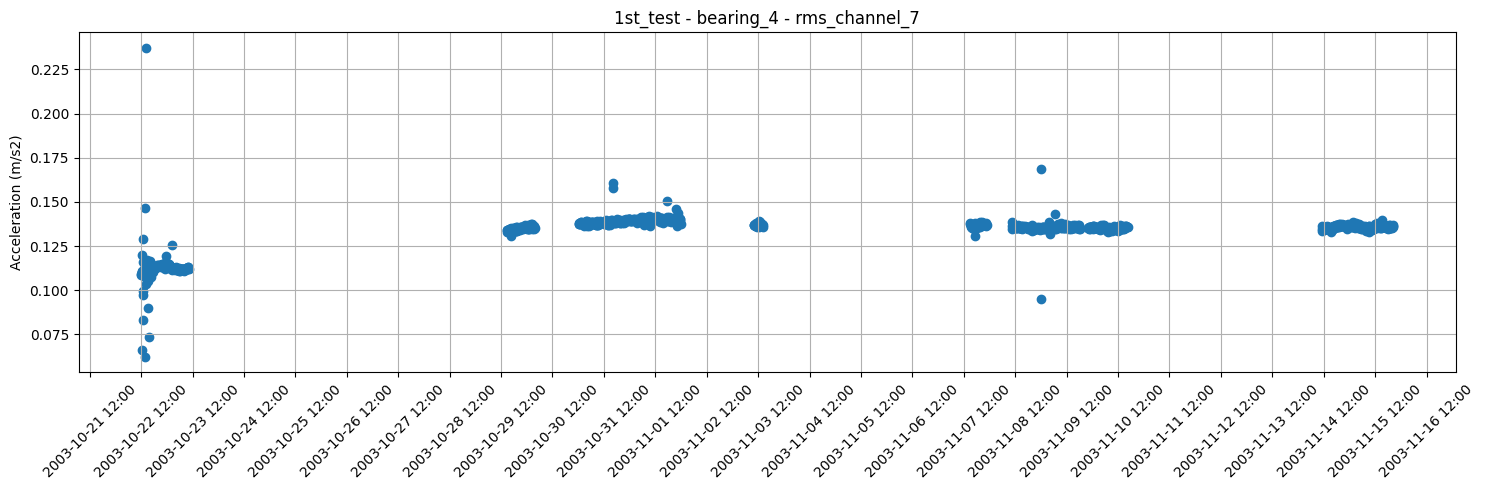

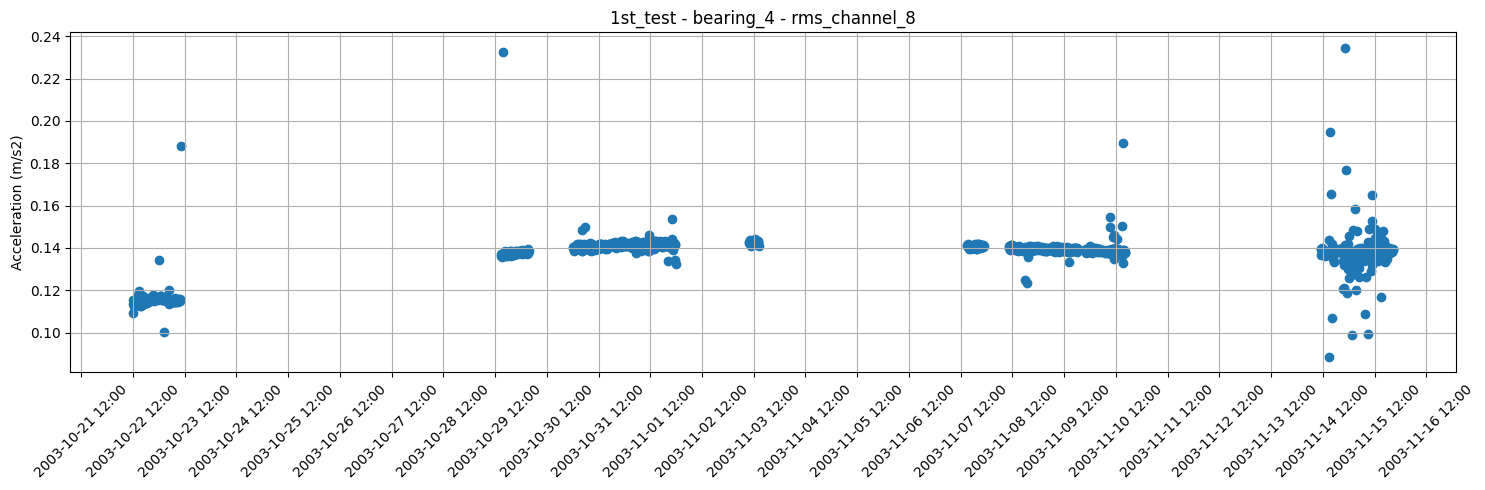

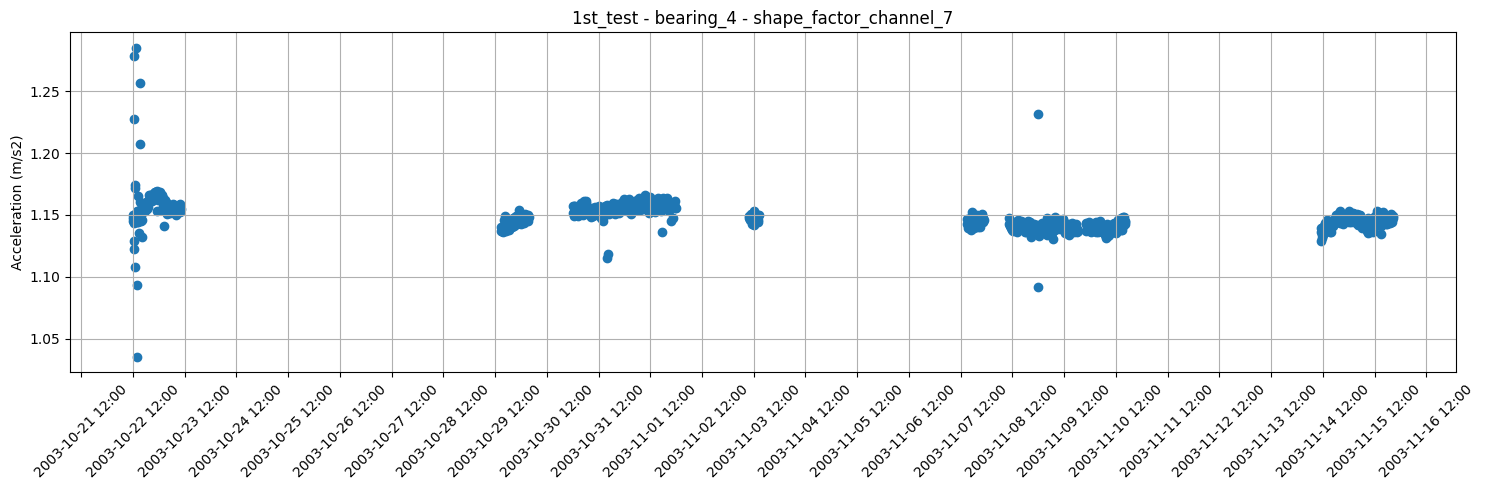

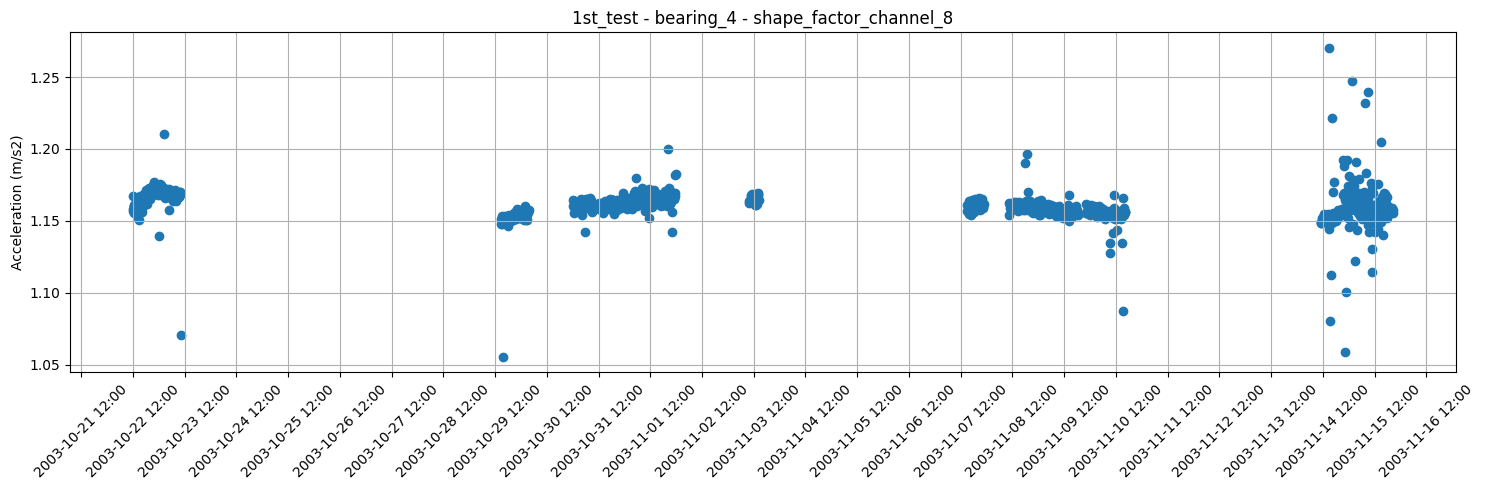

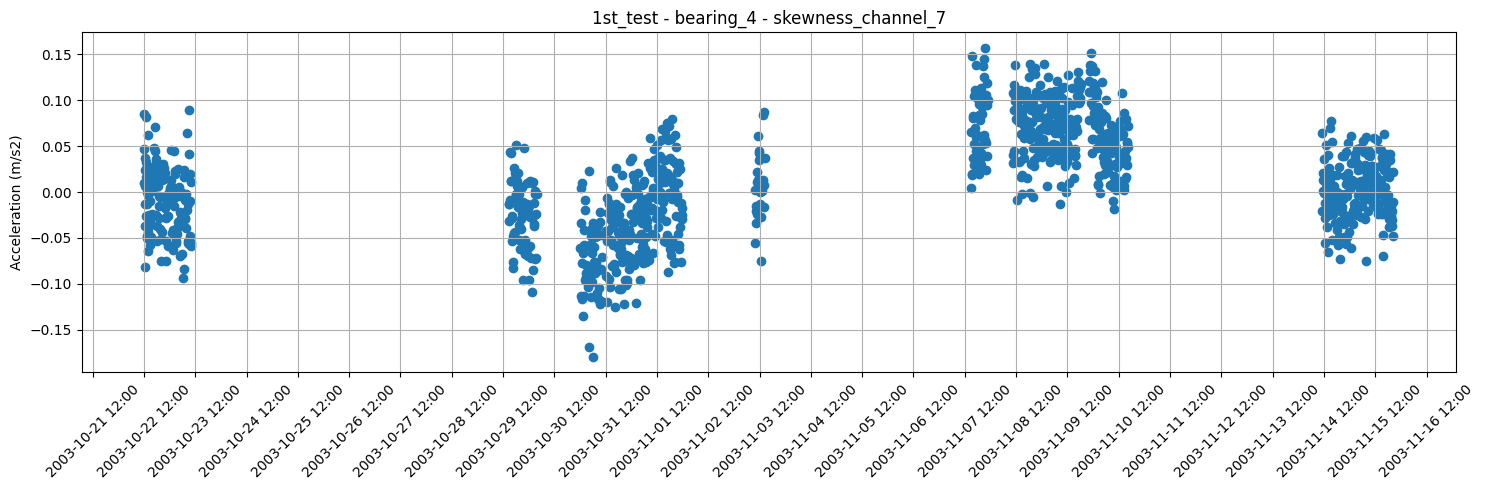

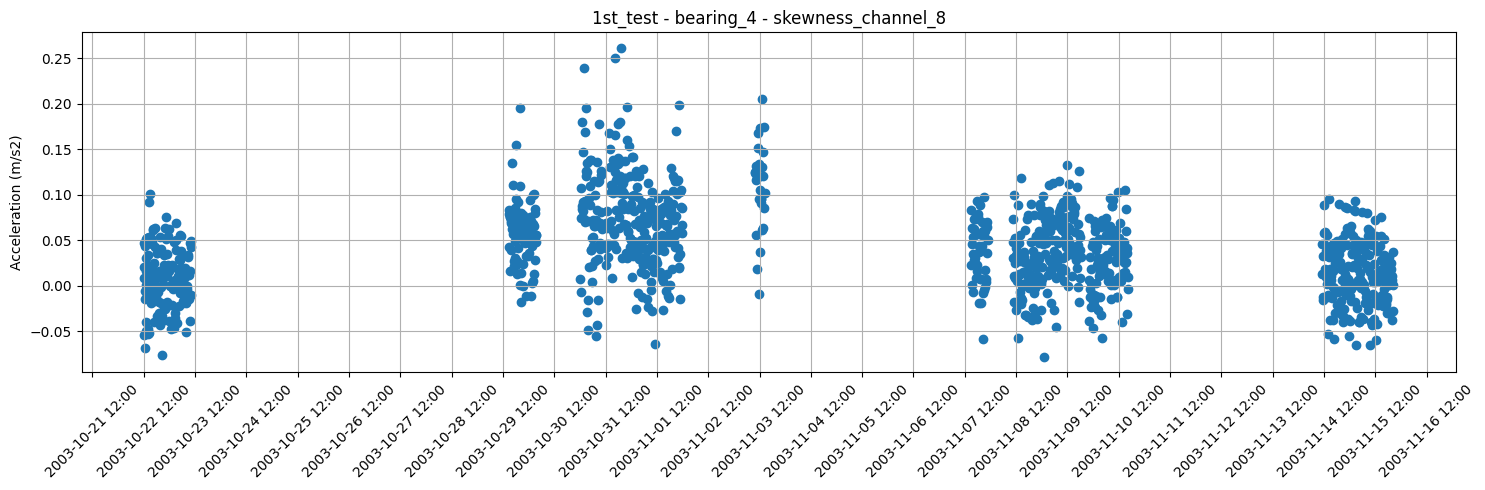

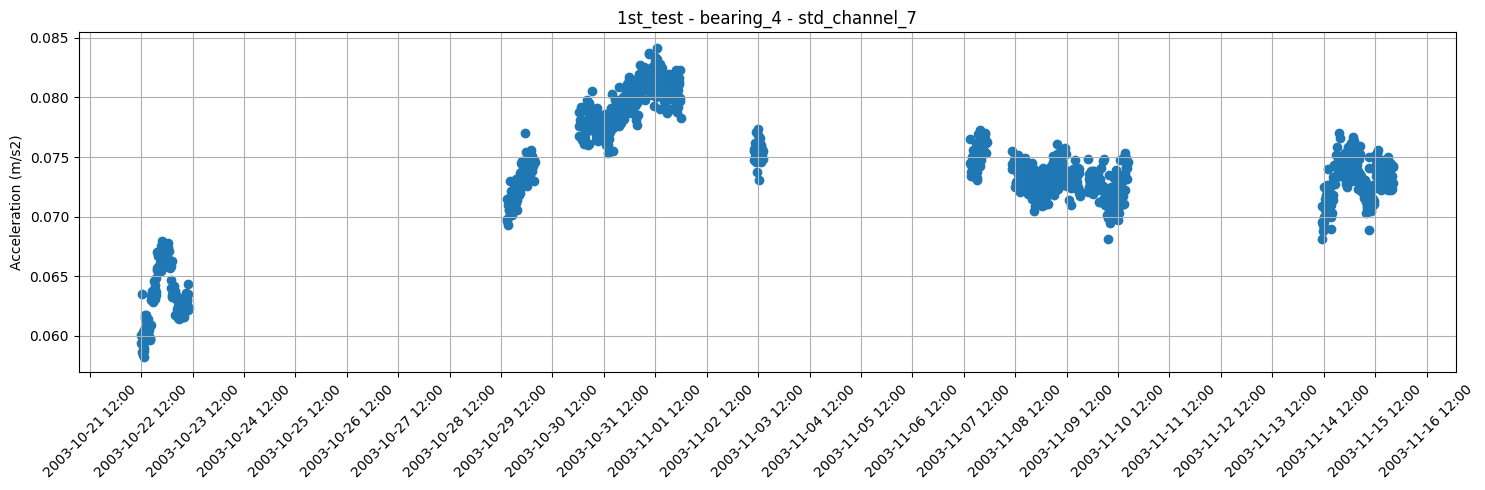

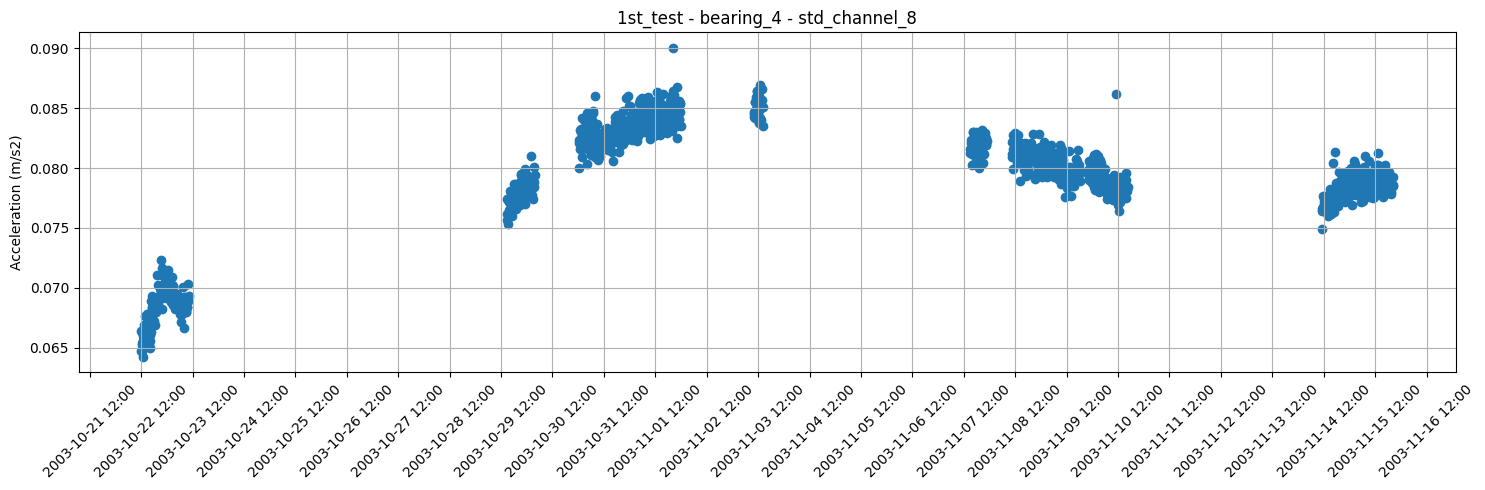

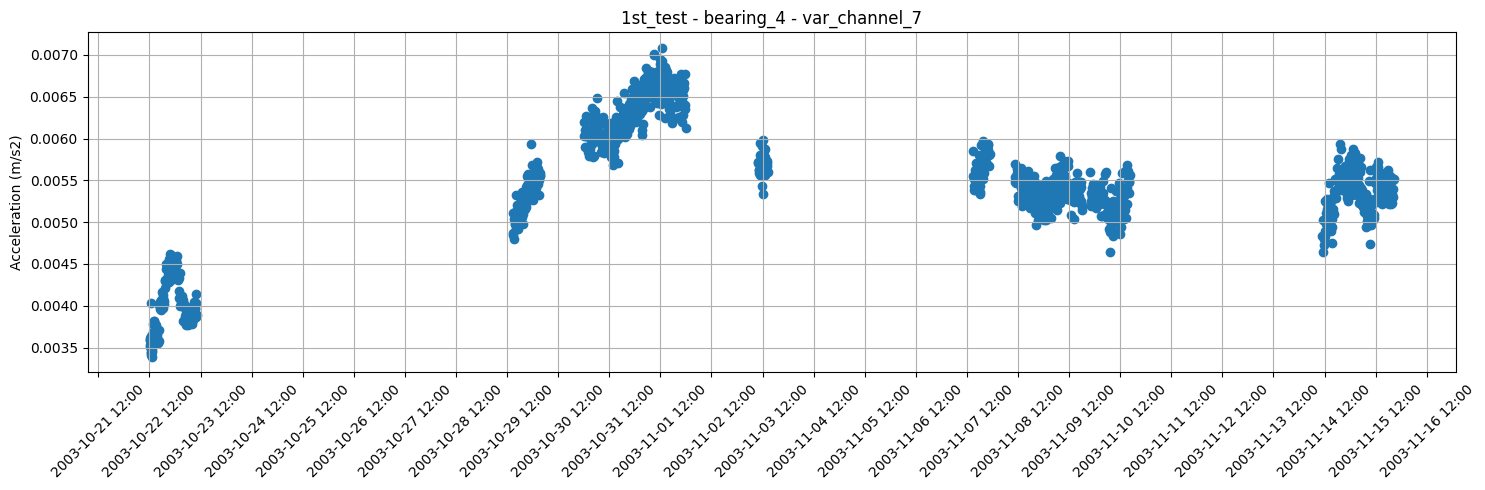

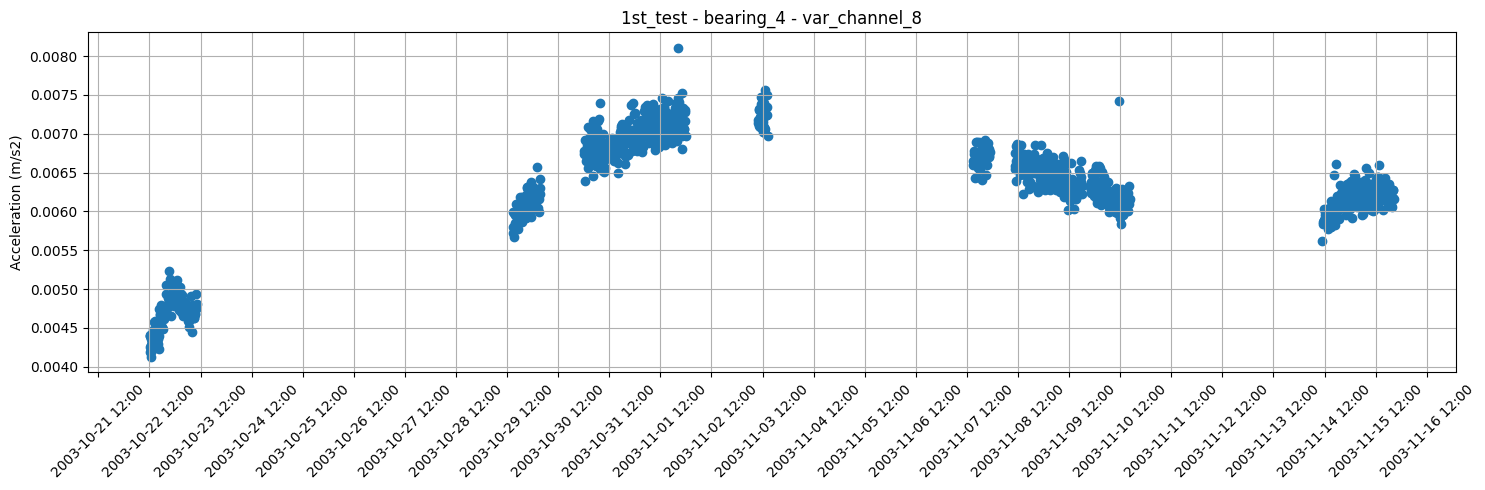

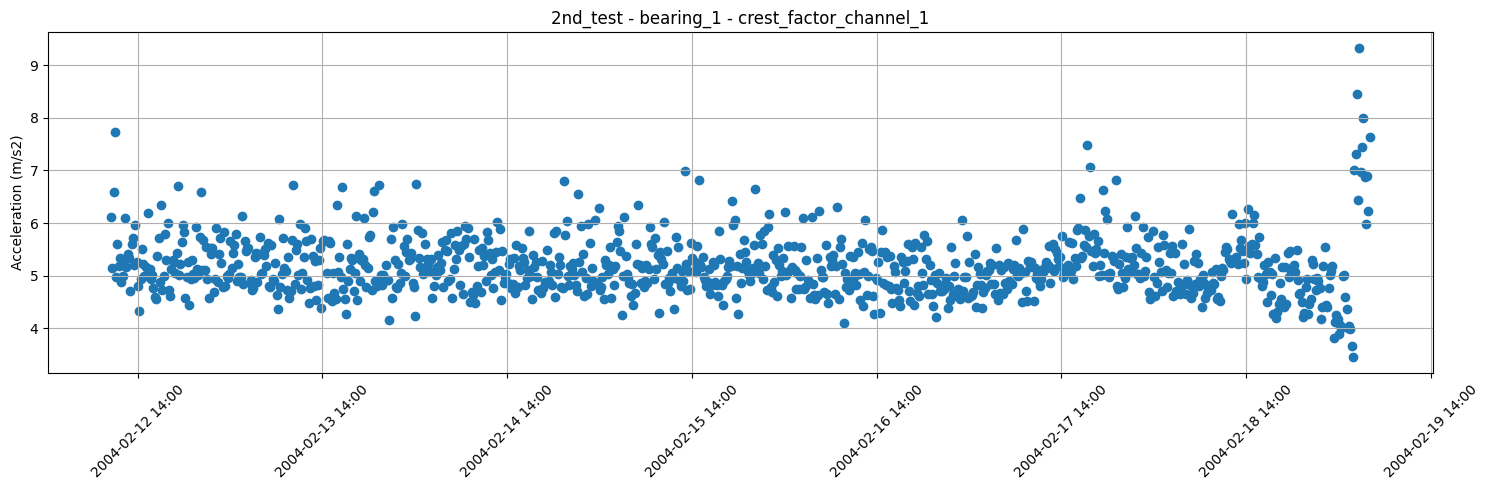

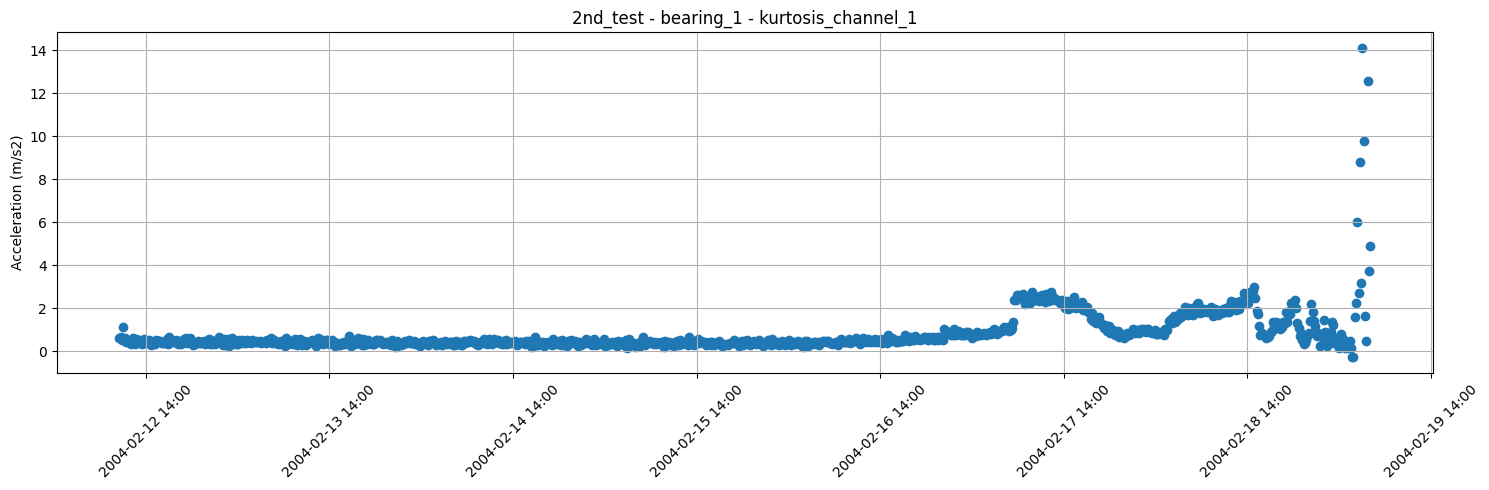

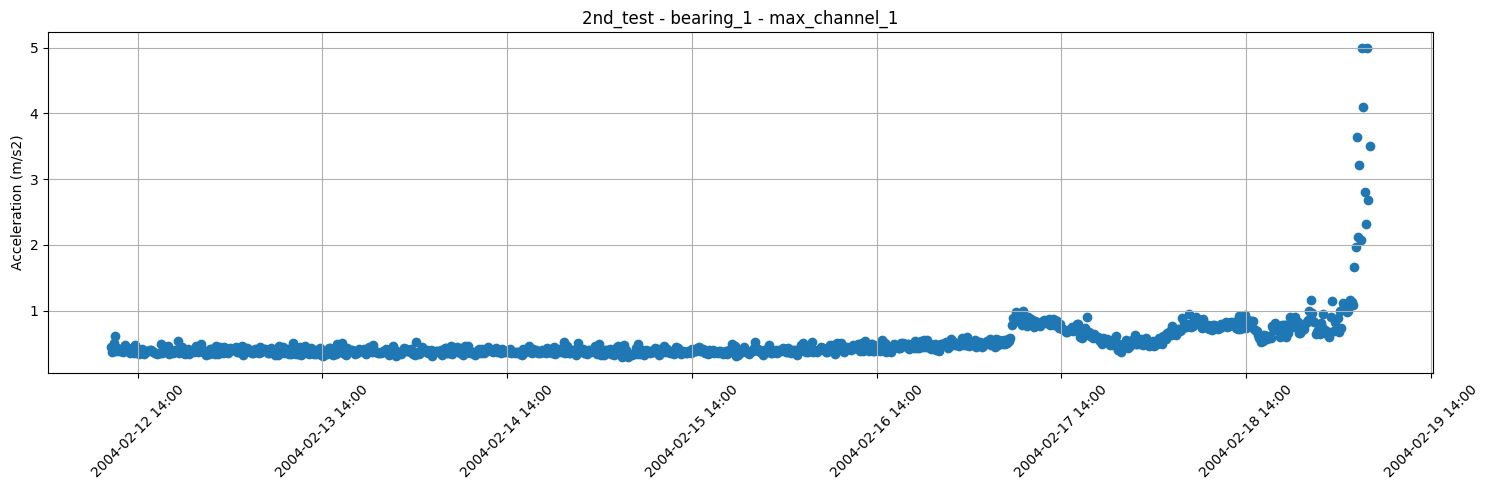

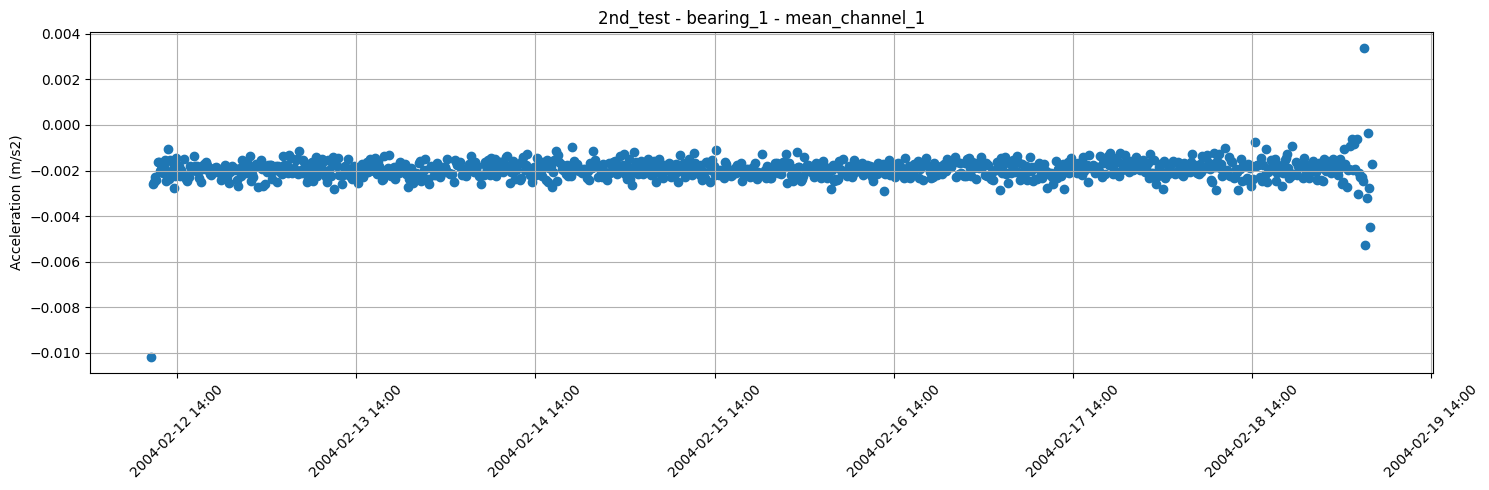

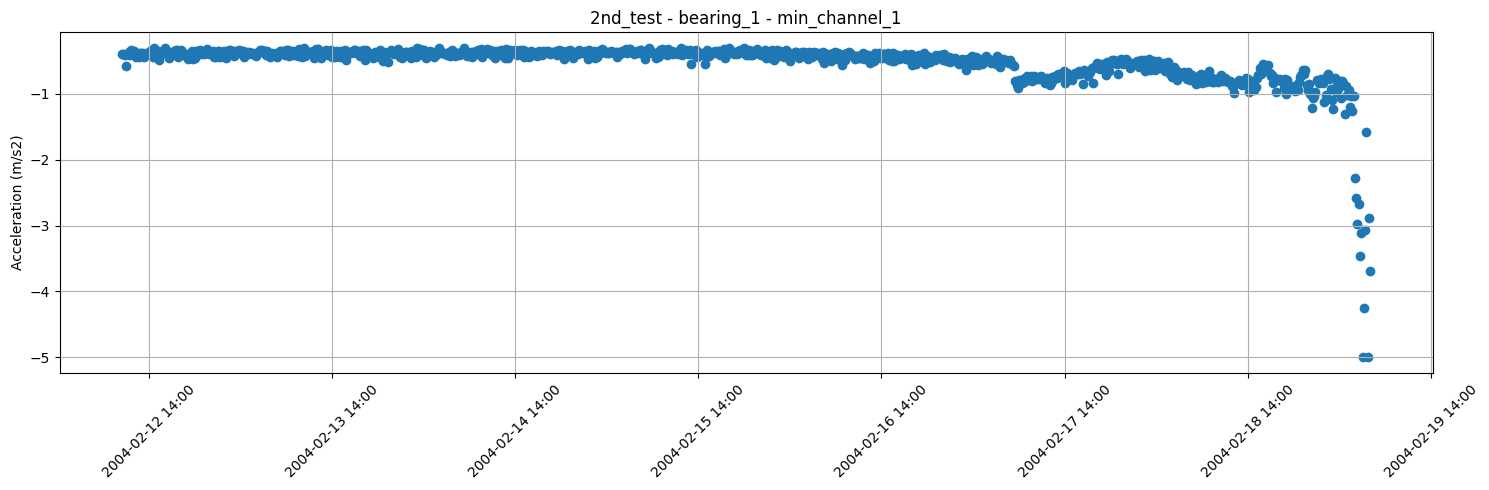

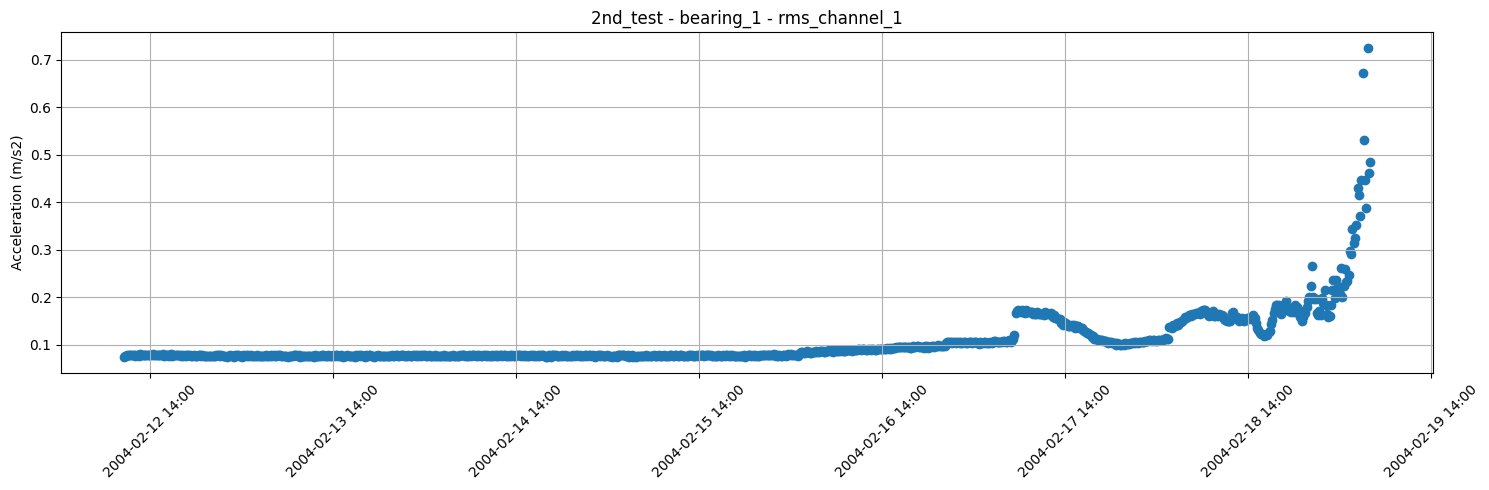

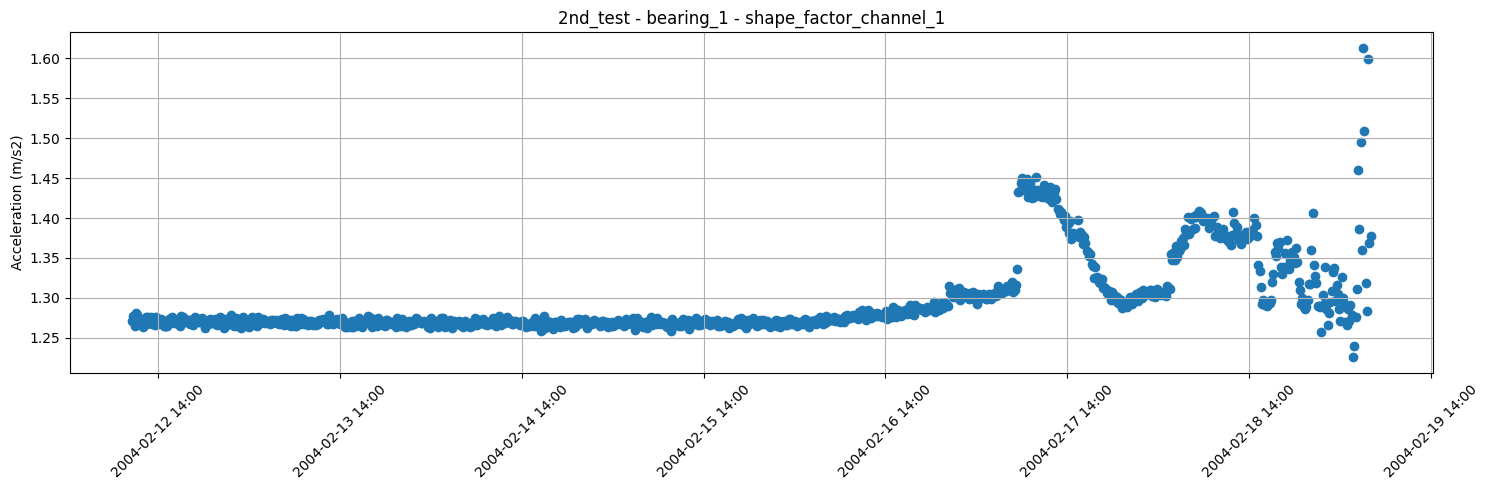

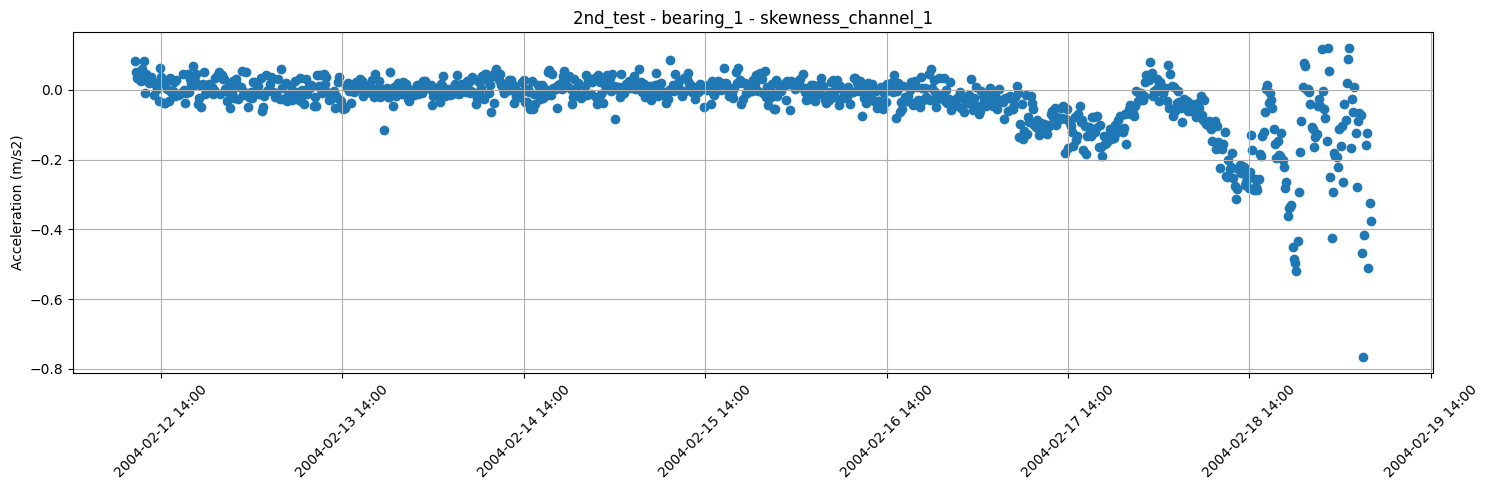

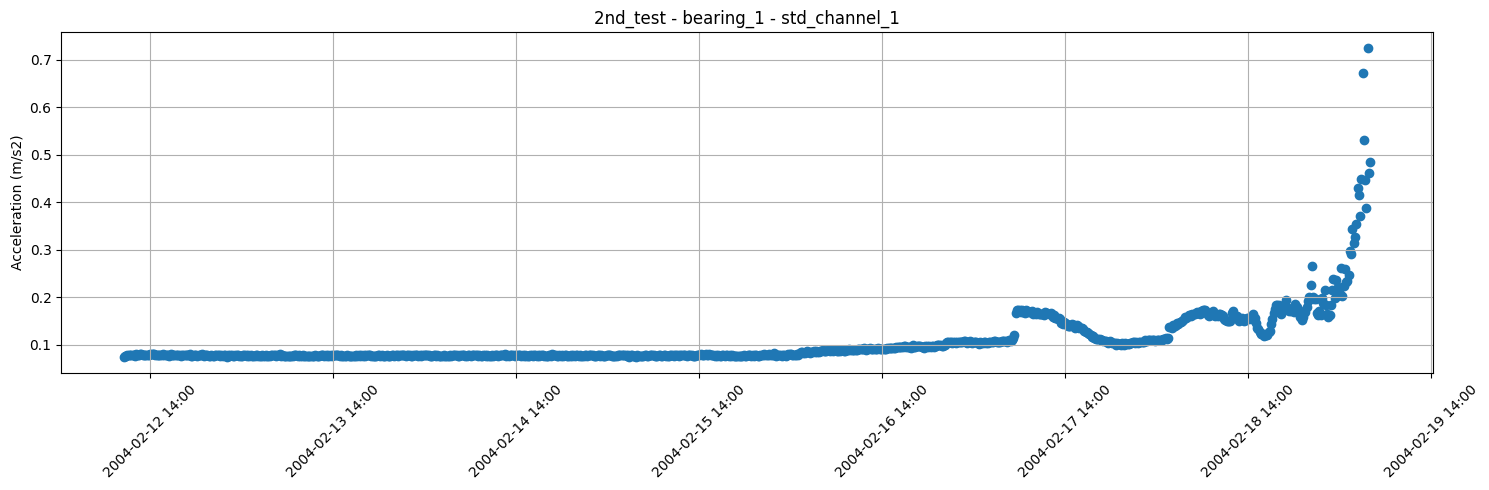

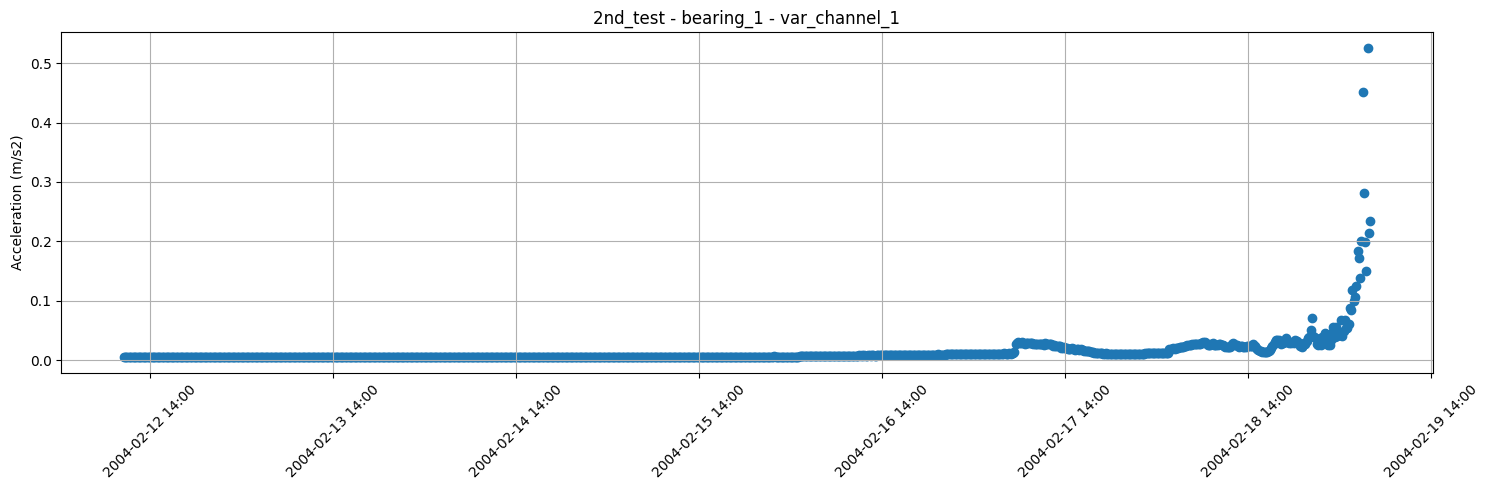

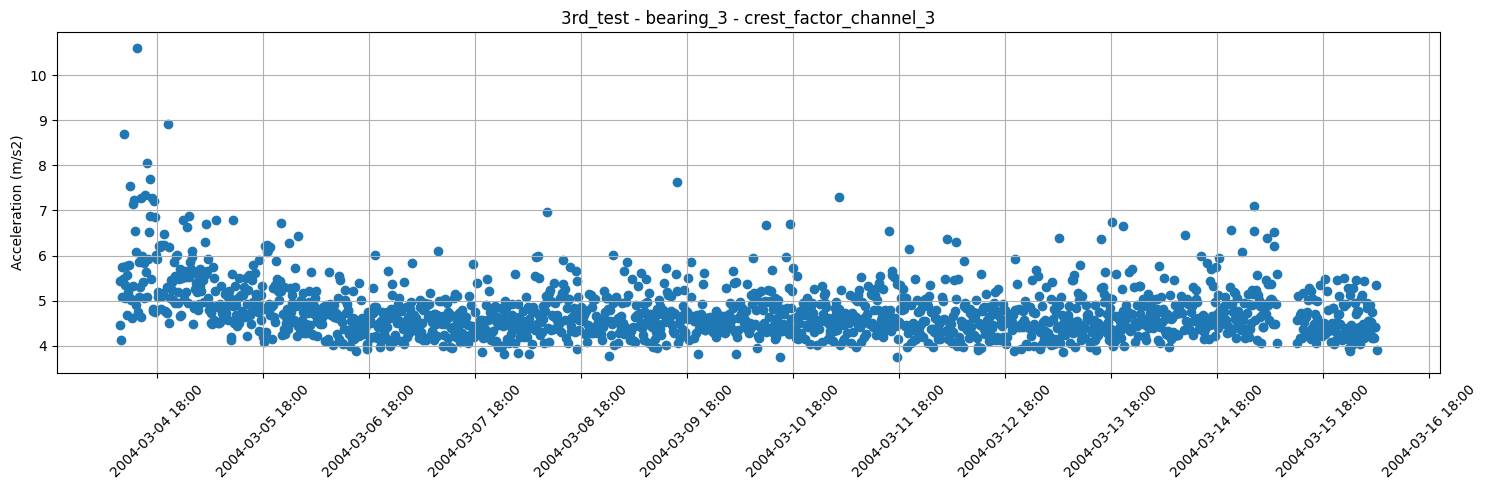

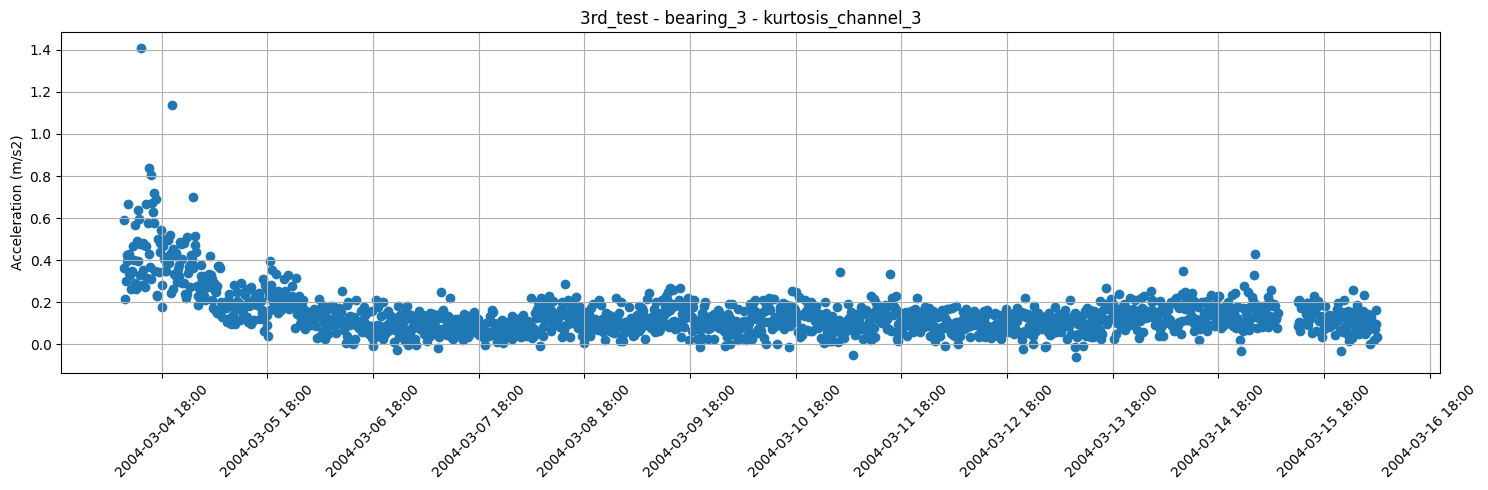

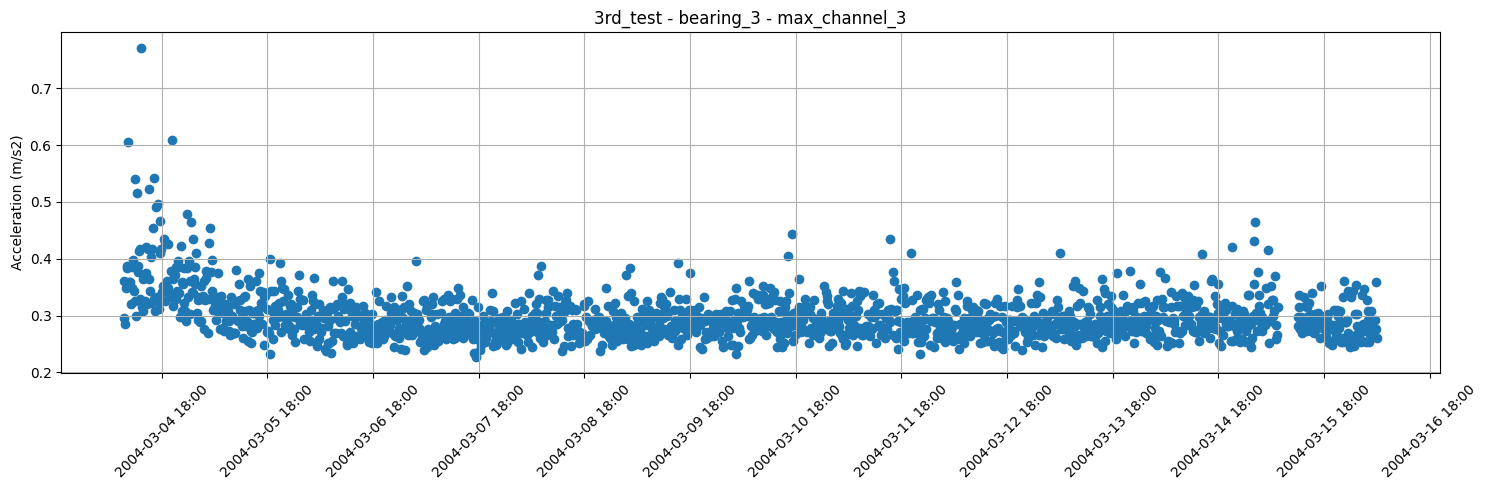

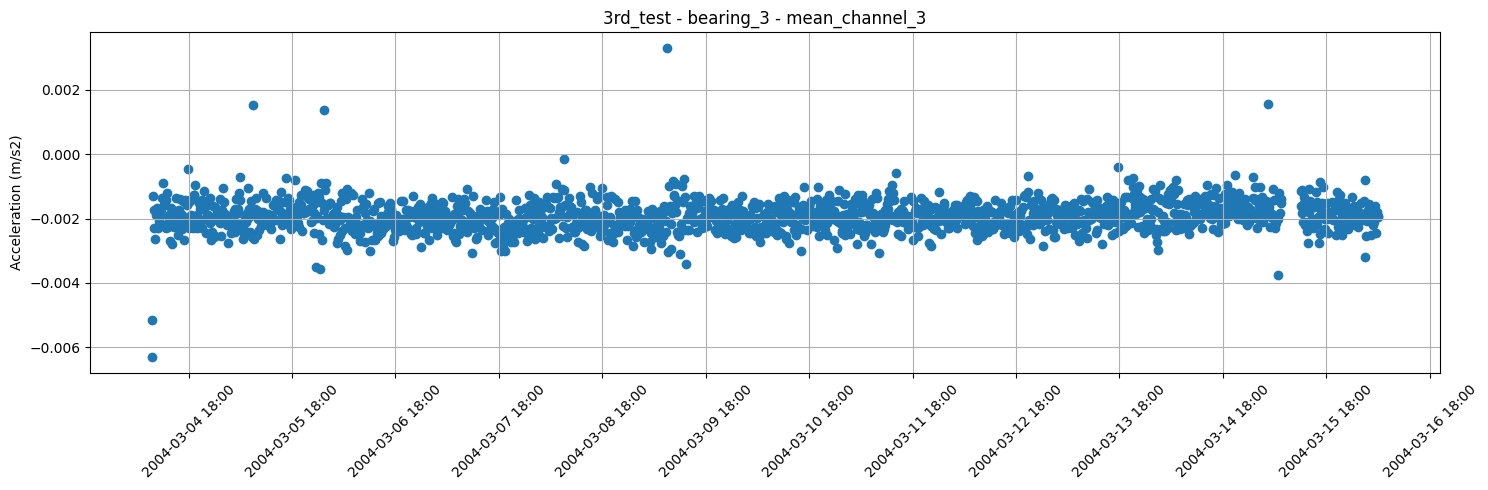

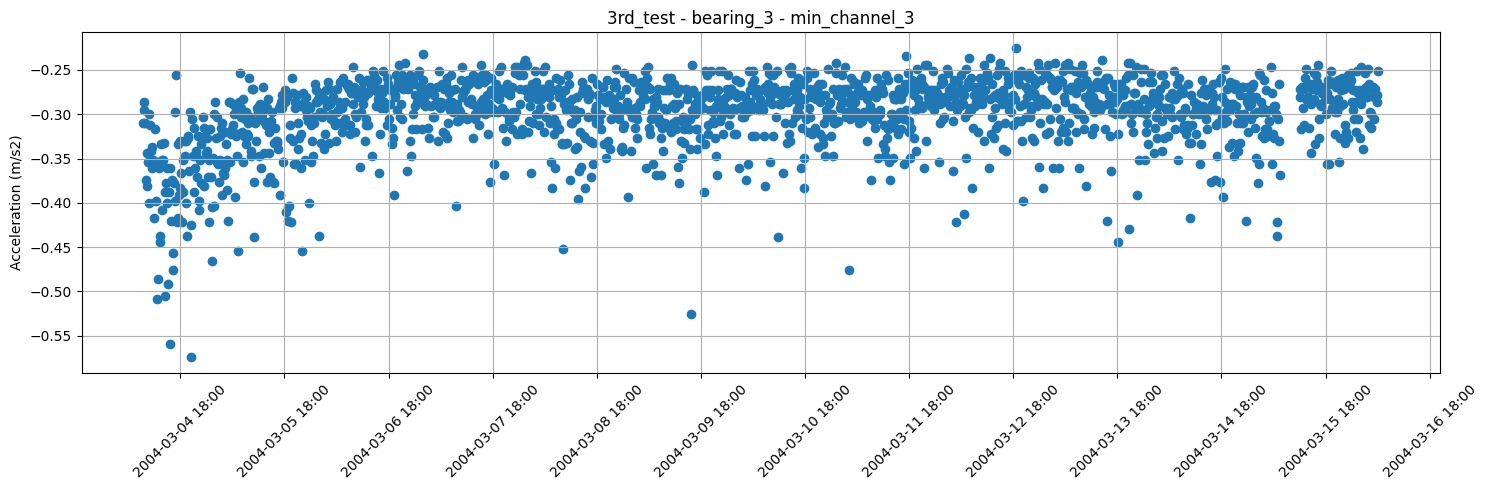

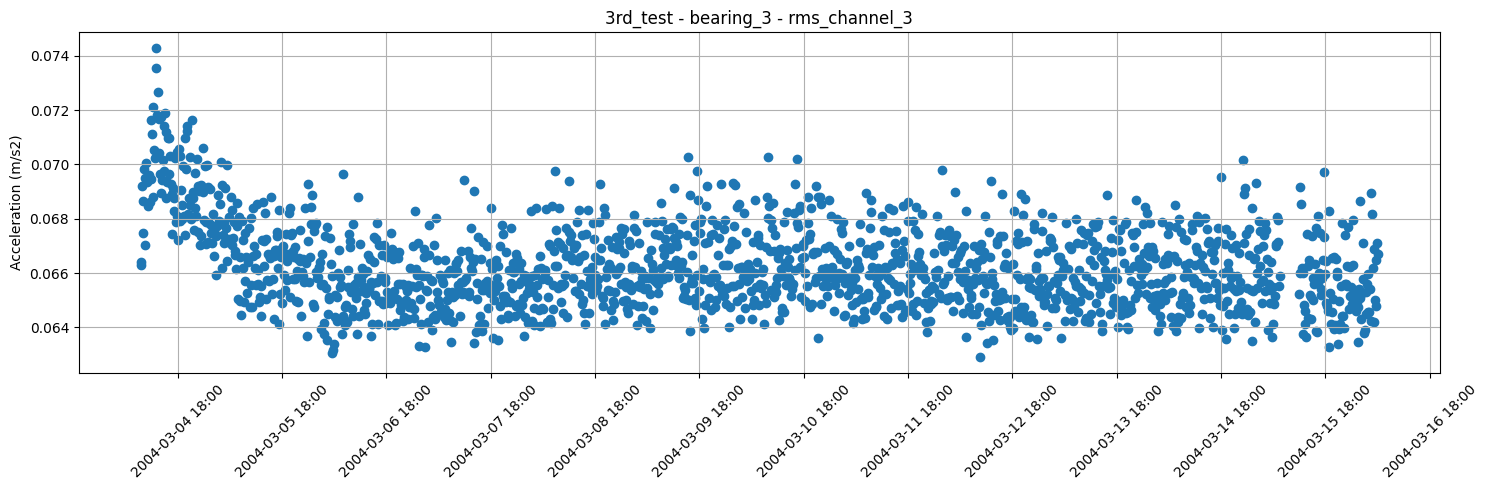

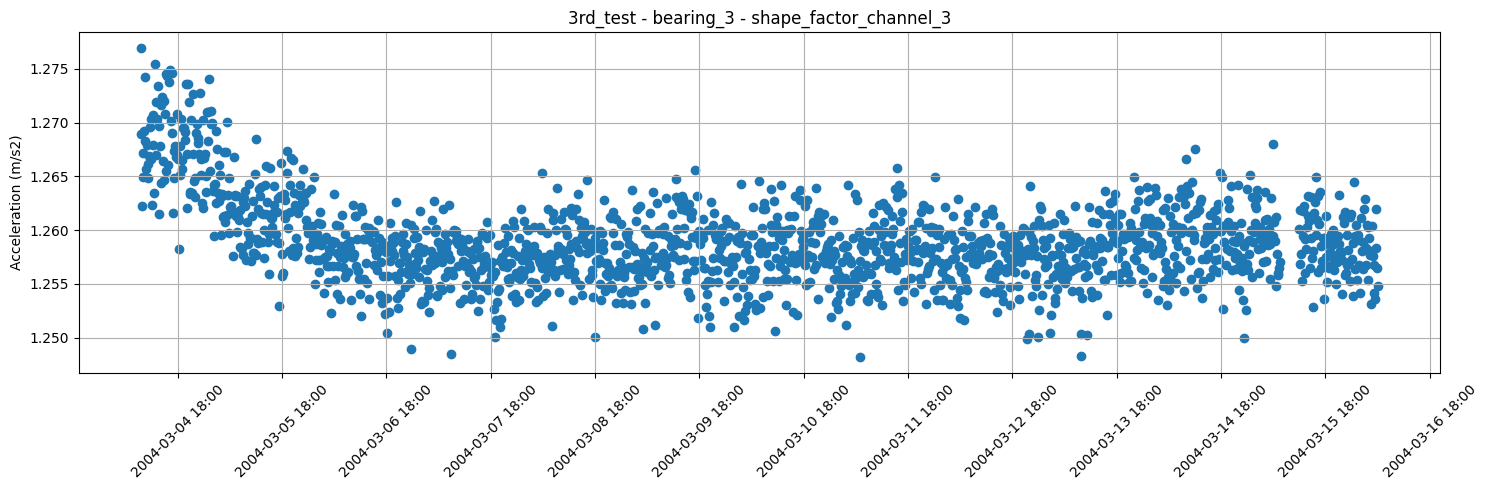

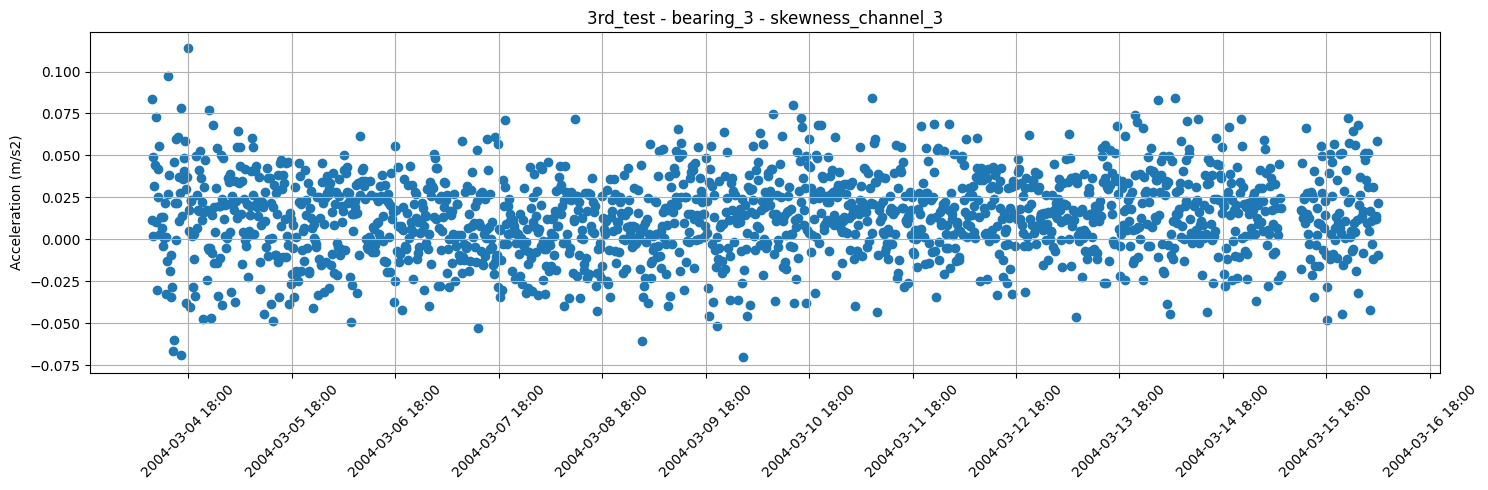

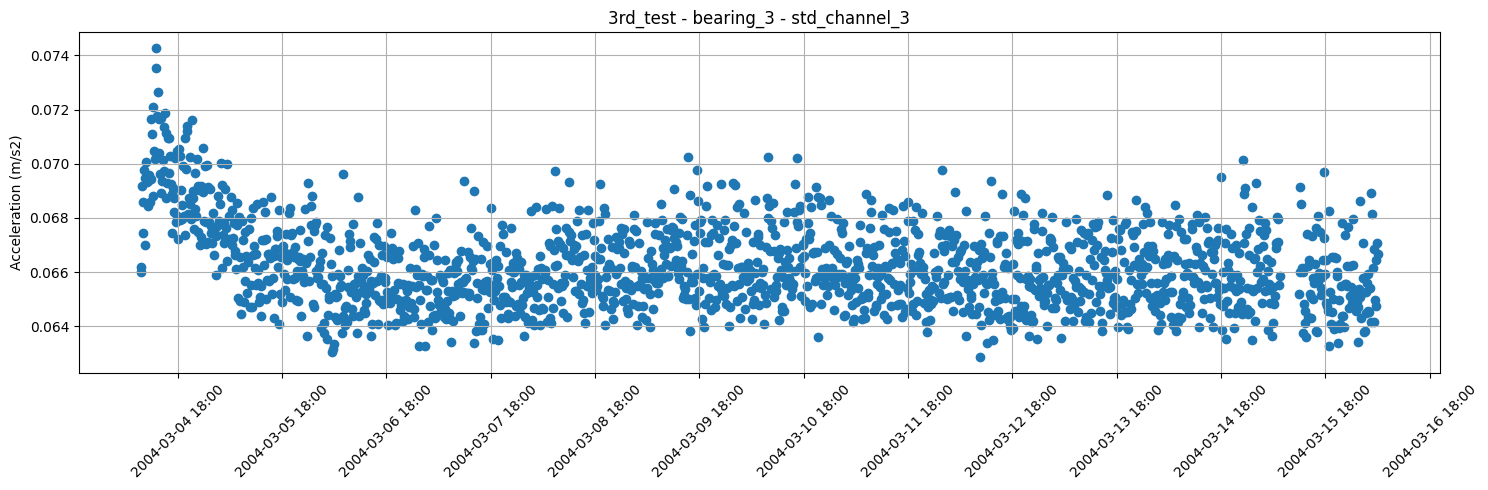

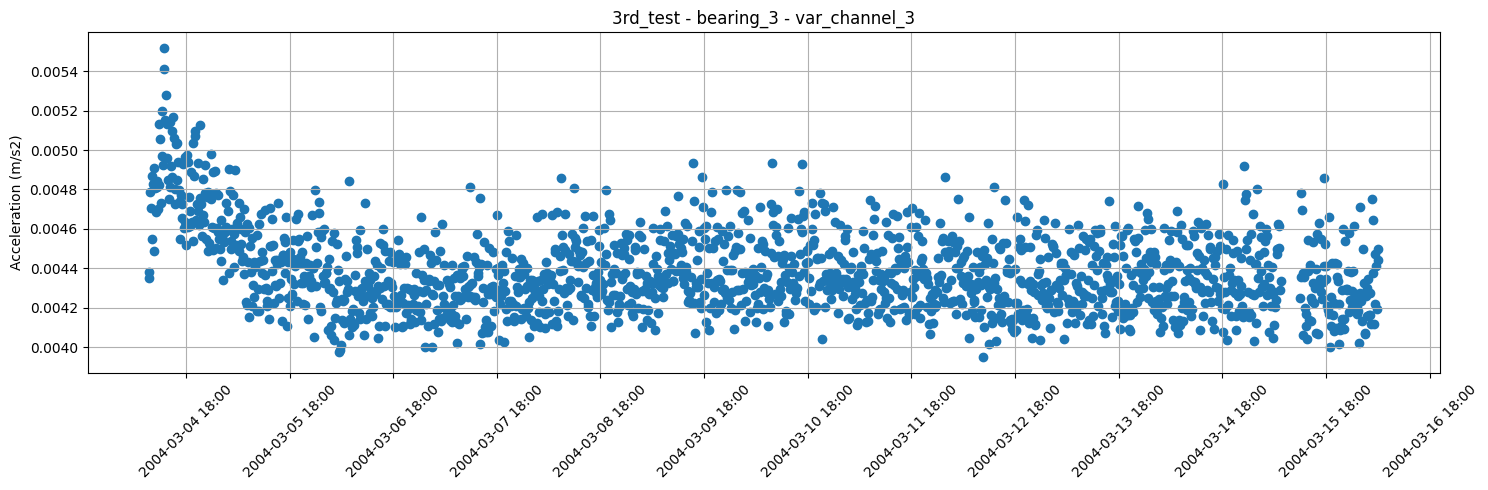

In [14]:
HEIGHT = 5
WIDTH = 15

for test, bearings_dict in all_aggregated_results.items():
    for faulty_bearing, aggregated_df_per_test in bearings_dict.items():
        plot_columns = np.sort([i for i in aggregated_df_per_test.columns if 'channel' in i])
        
        for plot_column in plot_columns:
            fig, ax = plt.subplots(figsize=(WIDTH, HEIGHT))
            
            ax.scatter(aggregated_df_per_test['date_time'], aggregated_df_per_test[plot_column])
            
            ax.xaxis.set_major_locator(mdates.HourLocator(interval=24))
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
            
            plt.ylabel('Acceleration (m/s2)')
            plt.xticks(rotation=45)
            plt.title(f'{test} - {faulty_bearing} - {plot_column}')
            plt.grid(True)
            
            plt.tight_layout()
            plt.show();

## Conclusions
Considering the aggregation plots, the following conclusions can be obtained:

- **1st test**: No evidence of the bearing failure according to the aggregation plots. In addition, it is interesting the gaps between the different measurements. That is not happening in the 2nd and 3rd tests, where the measurements look more continuous in time.

- **2nd test**: There is clear evidence of the moment when the bearing starts to fail. That happens between the 2004-02-16 and the 2004-02-17. The key parameter in this case is the shape factor, which abruply jumps from just above 1.25 to 1.45 the 2004-02-16. Besides, during that day and the previous a small increase starts to happen in the shape factor until it jumps at the end of the day. Other parameters such as the kurtosis, the standard deviation, the maximum, the minimum, the skewness, and the variance also show similar trends. From the 2004-02-16 until the 2024-02-18, the bearing seems to have failed, but it is not until the end of the 18th February when the different parameters have an exponential growth.

- **3rd test**: No evidence of bearing failure according to the aggregation plots. Nevertheless, it is interesting to see higher amplitudes at the beginning for some parameters such as the kurtosis, the standard deviation, the ariance, the shape factor, the root mean square, the minimum, and the maximum. That phenomenom looks opposite to what it was expected: having a greater vibration or amplitude level in those parameters at the end, when the bearing is suppoused to fail and not at the beginning.


## Summary

After analyzing the raw time-series or vibration signals, only for the 2nd test it has been possible to detect the bearing failure using simple and quick solutions:
- Comparison between the first and last measurement with histograms
- Obtaining different parameters per measurement such as the maximum, the minimum, the standard deviation, the variance, the kurtosis, the shape factor, the crest factor and others

On the other hand, the 1st and 3rd tests bearing failures could not be detected. Therefore, transforming the raw vibration data, which is in the time domain, to the frequency-domain might make sense for detecting the bearing failures.

Despite not having found the bearing failures for the three tests, it is worth it to start from the simplest solution to see if it is possible to find a bearing fault before jumping to the classical vibration analysis in the frequency-domain or more complex solutions based in machine learning models.